In this project on stock market prediction, I plan to train the dataset on the following models.

- SARIMA(X)<br>
- Facebook Prophet<br>
- Auto ARIMAX<br>
- LightGBM<br>
- LSTM<br>

## Content

1. Installing and Importing the Packages
2. Getting the Dataset
3. Getting to know the Dataset
4. Basic formating of the dataset
5. Splitting the dataset
6. EDA on training dataset

- Below, `%reload_ext autoreload` is a magic command in jupyter notebook that enables autoreloading of imported modules in IPython. It allows changes made to a module's code to be immediately reflected in the notebook, without having to manually restart the kernel or reload the module.
- `%autoreload 2` reloads all modules before executing a new line of code.
- `%matplotlib inline` helps to make visualization within the notebook

In [1]:
# INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Getting the required packages 

We first have to install the following packages using pip.
- package `pmdarima` for importing `auto_arima` module to train dataset with Auto ARIMAX model
- prophet for training Facebook Prophet
- lightgbm

In [2]:
#installing packages

#uncomment below if packages are not already installed in your local environment
#!pip install pmdarima
#!pip install lightgbm
#!pip install prophet --no-cache-dir

A `!` mark is needed before `pip` for shell command. If you are installing it in your local machine from command line interface (CLI), then you don't need this exclamation (`!`) mark.  

In [3]:
# importing PACKAGES:

# data analysis
import numpy as np
import pandas as pd

#ML model training
from pmdarima import auto_arima
from prophet import Prophet
import lightgbm as lgb

#evaluation metric
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, \
median_absolute_error, mean_squared_log_error

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
import itertools
warnings.filterwarnings("ignore")

# 2. Getting the dataset

- For link to the dataset: [Click here](https://www.kaggle.com/datasets/aayushmishra1512/faang-complete-stock-data?select=Netflix.csv).<br>

- Above dataset contains stocks of Apple for about 40 years from 1980 to 2020 

In [5]:
# make sure dataset with .csv extension is there in the directory
!ls

Apple.csv  LICENSE  README.md  stock-market-prediction.ipynb


In [6]:
#1. use read_csv function from pandas libraray to read the dataset 
#2. store contents of the file in a DataFrame object df
df = pd.read_csv("Apple.csv")

In [7]:
#print first 5 rows of the dtatset
df.head()

Date      Open      High       Low     Close  Adj Close       Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261  469033600.0
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978  175884800.0
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934  105728000.0
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   86441600.0
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   73449600.0

In the above dataset, 
- `Date` is in yyyy-mm-dd format
- **Adj Close** (Adjusted Close)  is the **target variable** to predict. 

## 3. Getting to know the dataset

In [8]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

We see above that, all features are numerics except, date. This makes sense. All features have their datatype as expected.

In [9]:
##Summary Statistics
df.describe().round(2)

Open      High       Low     Close  Adj Close        Volume
count  10015.00  10015.00  10015.00  10015.00   10015.00  1.001500e+04
mean       9.01      9.11      8.92      9.02       8.48  3.413188e+08
std       16.84     17.03     16.68     16.87      16.47  3.426534e+08
min        0.05      0.05      0.05      0.05       0.04  1.388800e+06
25%        0.27      0.28      0.26      0.27       0.23  1.315944e+08
50%        0.44      0.45      0.43      0.44       0.37  2.285380e+08
75%       10.06     10.18      9.89     10.10       8.73  4.250092e+08
max      132.76    134.80    130.53    134.18     134.18  7.421641e+09

In [10]:
# Getting the basic information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10016 non-null  object 
 1   Open       10015 non-null  float64
 2   High       10015 non-null  float64
 3   Low        10015 non-null  float64
 4   Close      10015 non-null  float64
 5   Adj Close  10015 non-null  float64
 6   Volume     10015 non-null  float64
dtypes: float64(6), object(1)
memory usage: 547.9+ KB


In [11]:
df.shape

(10016, 7)

In [12]:
df['Date'].min()

'1980-12-12'

In [13]:
df['Date'].max()

'2020-09-01'

Thus we have have datas for about 40 years in 10k rows.

## 4. Basic formatting of the dataset 

### Making all feature names consistent i.e. all are small letters and spaces are replaced by a underscore `_` 

In [14]:
df.columns  = df.columns.str.lower().str.replace(' ','_')

In [15]:
df.head()

date      open      high       low     close  adj_close       volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261  469033600.0
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978  175884800.0
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934  105728000.0
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   86441600.0
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   73449600.0

### Converting the Date column from Object data type to Datetime64 format

We have to change the datatype of `date` feature from `object` to `datetime` before we proceed with any time series analysis. Look into Pandas [time series](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) for these tools.

In [16]:
# Converting the Date column from Object data type to Datetime64 format:
df.date = pd.to_datetime(df.date,format='%Y-%m-%d')

In [17]:
# Getting the basic information after dtype change:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       10016 non-null  datetime64[ns]
 1   open       10015 non-null  float64       
 2   high       10015 non-null  float64       
 3   low        10015 non-null  float64       
 4   close      10015 non-null  float64       
 5   adj_close  10015 non-null  float64       
 6   volume     10015 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 547.9 KB


We see that dtype of `date` is now changed to `datetime64[ns]`.

In [18]:
df.dtypes

date         datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume              float64
dtype: object

### Missing Values

In [19]:
# Getting the sum count of missing values in each column:
df.isnull().sum()

date         0
open         1
high         1
low          1
close        1
adj_close    1
volume       1
dtype: int64

We have very small amount of missing data. We can just ignore them by deleting the missing values.

In [20]:
#delete the row with nan values
df.dropna(inplace=True)

In [21]:
df.isna().values.any()

False

### Setting the indices of dataset into dates

In [22]:
df.head()

date      open      high       low     close  adj_close       volume
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261  469033600.0
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978  175884800.0
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934  105728000.0
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   86441600.0
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   73449600.0

In [23]:
df.set_index("date", drop=False, inplace=True)

In [24]:
df.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  
date                     
1980-12-12  469033600.0  
1980-12-15  175884800.0  
1980-12-16  105728000.0  
1980-12-17   86441600.0  
1980-12-18   73449600.0

### Selecting data only after 2012 to use

In [25]:
df = df[pd.to_datetime(df.index).year >= 2012]

In [26]:
df.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  
date                     
2012-01-03  302220800.0  
2012-01-04  260022000.0  
2012-01-05  271269600.0  
2012-01-06  318292800.0  
2012-01-09  394024400.0

In [27]:
df.tail()

date        open        high         low       close  \
date                                                                    
2020-08-26 2020-08-26  126.180000  126.992500  125.082497  126.522499   
2020-08-27 2020-08-27  127.142502  127.485001  123.832497  125.010002   
2020-08-28 2020-08-28  126.012497  126.442497  124.577499  124.807503   
2020-08-31 2020-08-31  127.580002  131.000000  126.000000  129.039993   
2020-09-01 2020-09-01  132.759995  134.800003  130.529999  134.179993   

             adj_close       volume  
date                                 
2020-08-26  126.522499  163022400.0  
2020-08-27  125.010002  155552400.0  
2020-08-28  124.807503  187630000.0  
2020-08-31  129.039993  225702700.0  
2020-09-01  134.179993  151948100.0

# 5. Splitting the dataset 

**REMEMBER** We don't shuffle data in time-series unlike usual tabular data, because if we shuffle, then the model may know the future data by mistake causing data-leakage.

We'll splitt the data into train, validation and test (60/20/20).

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
df_full_train, df_test = train_test_split(df, test_size=0.2, shuffle = False)

In [30]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle = False)

In [31]:
df_train.tail()

date       open       high        low      close  adj_close  \
date                                                                           
2017-03-09 2017-03-09  34.685001  34.697498  34.262501  34.669998  33.034672   
2017-03-10 2017-03-10  34.812500  34.840000  34.660000  34.785000  33.144257   
2017-03-13 2017-03-13  34.712502  34.857498  34.705002  34.799999  33.158543   
2017-03-14 2017-03-14  34.825001  34.912498  34.709999  34.747501  33.108528   
2017-03-15 2017-03-15  34.852501  35.187500  34.757500  35.115002  33.458694   

                 volume  
date                     
2017-03-09   88623600.0  
2017-03-10   78451200.0  
2017-03-13   69686800.0  
2017-03-14   61236400.0  
2017-03-15  102767200.0

In [32]:
df_val.head()

date       open       high        low      close  adj_close  \
date                                                                           
2017-03-16 2017-03-16  35.180000  35.255001  35.064999  35.172501  33.513470   
2017-03-17 2017-03-17  35.250000  35.250000  34.972500  34.997501  33.346737   
2017-03-20 2017-03-20  35.099998  35.375000  35.057499  35.365002  33.696899   
2017-03-21 2017-03-21  35.527500  35.700001  34.932499  34.959999  33.311001   
2017-03-22 2017-03-22  34.962502  35.400002  34.939999  35.355000  33.687370   

                 volume  
date                     
2017-03-16   76928000.0  
2017-03-17  175540000.0  
2017-03-20   86168000.0  
2017-03-21  158119600.0  
2017-03-22  103440800.0

In [33]:
df_val.tail()

date       open       high        low      close  adj_close  \
date                                                                           
2018-11-29 2018-11-29  45.665001  45.700001  44.424999  44.887501  43.920044   
2018-11-30 2018-11-30  45.072498  45.082500  44.257500  44.645000  43.682777   
2018-12-03 2018-12-03  46.115002  46.235001  45.302502  46.205002  45.209152   
2018-12-04 2018-12-04  45.237499  45.597500  44.067501  44.172501  43.220459   
2018-12-06 2018-12-06  42.939999  43.695000  42.605000  43.680000  42.738575   

                 volume  
date                     
2018-11-29  167080000.0  
2018-11-30  158126000.0  
2018-12-03  163210000.0  
2018-12-04  165377200.0  
2018-12-06  172393600.0

In [34]:
df_test.head()

date       open       high        low      close  adj_close  \
date                                                                           
2018-12-07 2018-12-07  43.372501  43.622501  42.075001  42.122501  41.214645   
2018-12-10 2018-12-10  41.250000  42.522499  40.832500  42.400002  41.486164   
2018-12-11 2018-12-11  42.915001  42.947498  41.750000  42.157501  41.248890   
2018-12-12 2018-12-12  42.599998  42.980000  42.255001  42.275002  41.363853   
2018-12-13 2018-12-13  42.622501  43.142502  42.387501  42.737499  41.816387   

                 volume  
date                     
2018-12-07  169126400.0  
2018-12-10  248104000.0  
2018-12-11  189126800.0  
2018-12-12  142510800.0  
2018-12-13  127594400.0

We see above that splitting is done successfully without random shuffling.

In [35]:
len(df_train), len(df_val), len(df_test), len(df_full_train),  len(df_train)+len(df_val), len(df_train)+len(df_val)+\
len(df_test), len(df)

(1308, 436, 437, 1744, 1744, 2181, 2181)

Above we see that lengths of the dataframes after after splitting are consistent.

## 6. EDA on training dataset

## Missing value

In [36]:
df_train.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  
date                     
2012-01-03  302220800.0  
2012-01-04  260022000.0  
2012-01-05  271269600.0  
2012-01-06  318292800.0  
2012-01-09  394024400.0

In [37]:
df_train.isnull().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

We have negligible number od missing values. We'll neglect them for now.

Let's plot the variable `volume` over time

<AxesSubplot: xlabel='date'>

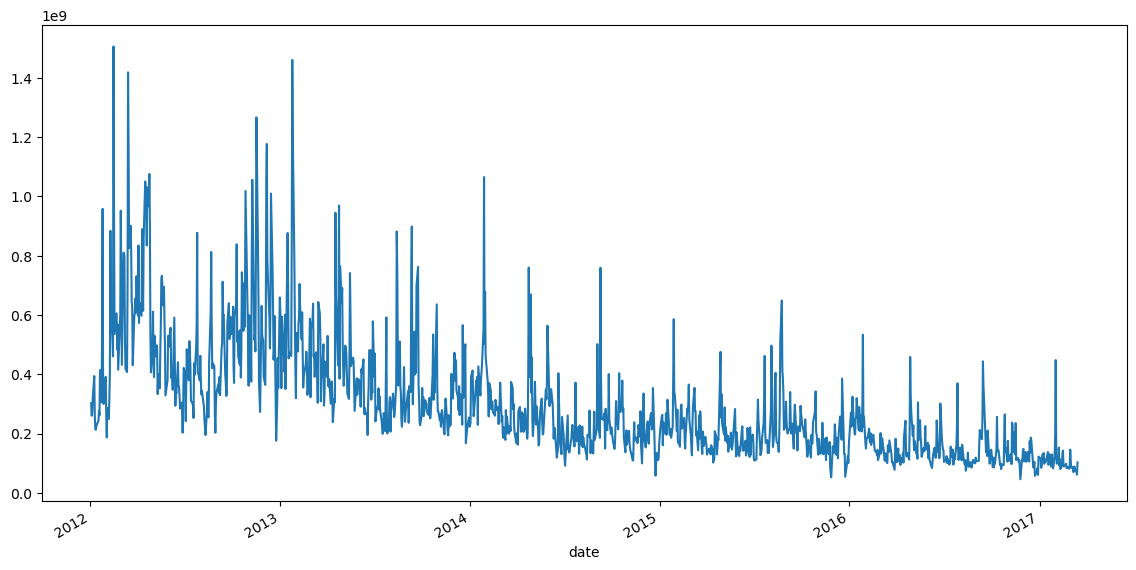

In [38]:
df_train.volume.plot(figsize=(14, 7))

Now our x-axis is along year. We see a very random behavior of volume with time axis here and no clear conclusions can be made here. 

### What is the trend in closing price of stock (adj_close) with time? 

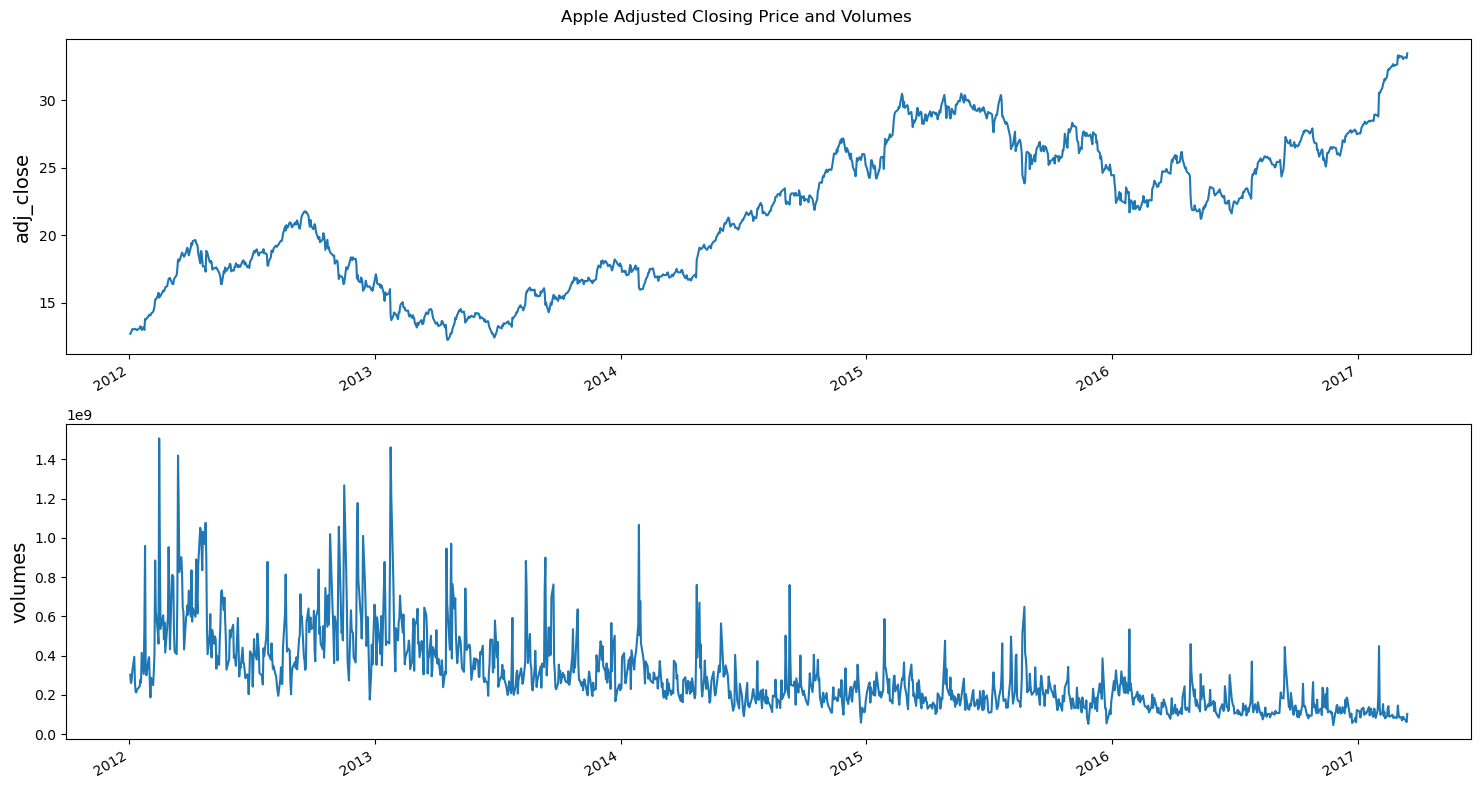

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plotting Apple's adjusted closing price (adj_close):
df_train['adj_close'].plot(ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('adj_close',fontsize=14)

# Creating a line plot for Apple's stock Volumes:
df_train['volume'].plot(ax=axes[1])
axes[1].set_ylabel('volumes', fontsize=14)
axes[1].set_xlabel('')  # to get nothing in x axis as labels

plt.suptitle('Apple Adjusted Closing Price and Volumes')
plt.tight_layout()
plt.show()

We can relate in the above figure that, 
* when closing prices abruptly increases or decreases, this causes a peak in volume i.e. the number of stocks sold or bought that day
* In the period around 2000, there was a peak in Apple's stock prices.

It would be intresting to compare in one plot how `adj_close` and `close` trends. 

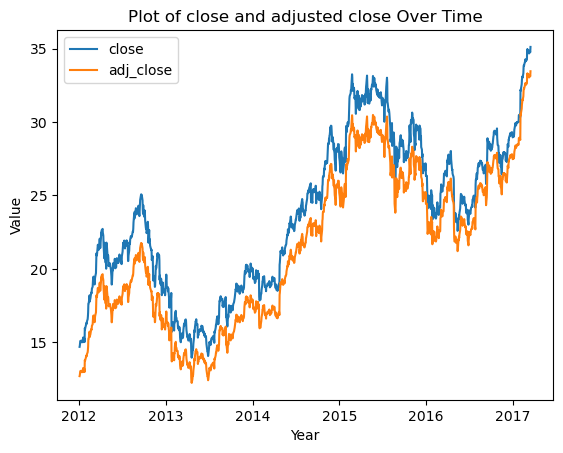

In [40]:
# Plot the columns using matplotlib
plt.plot(df_train.index, df_train['close'], label="close")
plt.plot(df_train.index, df_train['adj_close'], label="adj_close")

# Add a legend, axis labels, and title
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Plot of close and adjusted close Over Time")

# Show the plot
plt.show()

We see in the above figure that close and adjusted close follows the same trend.

Next we'll see how `open` and `close` compared in the same plot. 

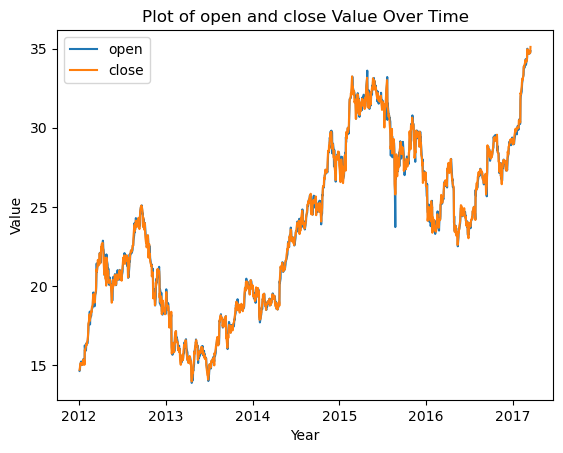

In [41]:
# Plot the columns using matplotlib
plt.plot(df_train.index, df_train['open'], label="open")
plt.plot(df_train.index, df_train['close'], label="close")

# Add a legend, axis labels, and title
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Plot of open and close Value Over Time")

# Show the plot
plt.show()

Open and close are almost indstiguisable at this scale with bare eye.

Now we'll plot open, close, high and low in the same plot.

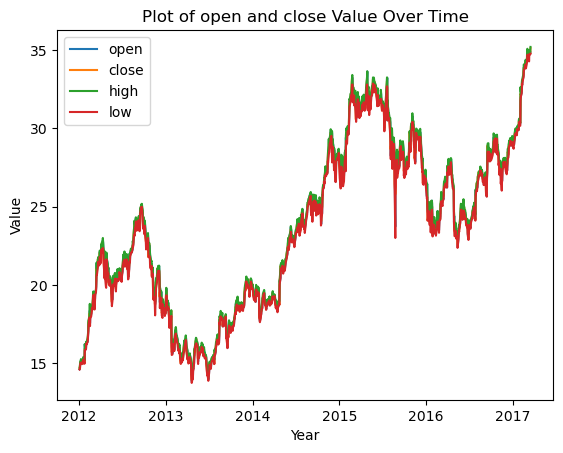

In [42]:
# Plot the columns using matplotlib
plt.plot(df_train.index, df_train['open'], label="open")
plt.plot(df_train.index, df_train['close'], label="close")
plt.plot(df_train.index, df_train['high'], label="high")
plt.plot(df_train.index, df_train['low'], label="low")

# Add a legend, axis labels, and title
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Plot of open and close Value Over Time")

# Show the plot
plt.show()

- Sometimes high in green are visible. All of them folllow the same trend at this scale.

### Moving average of Apple stock

This is done to smoothen the data. 50 day and 200 days moving averages are common among traders and investors.

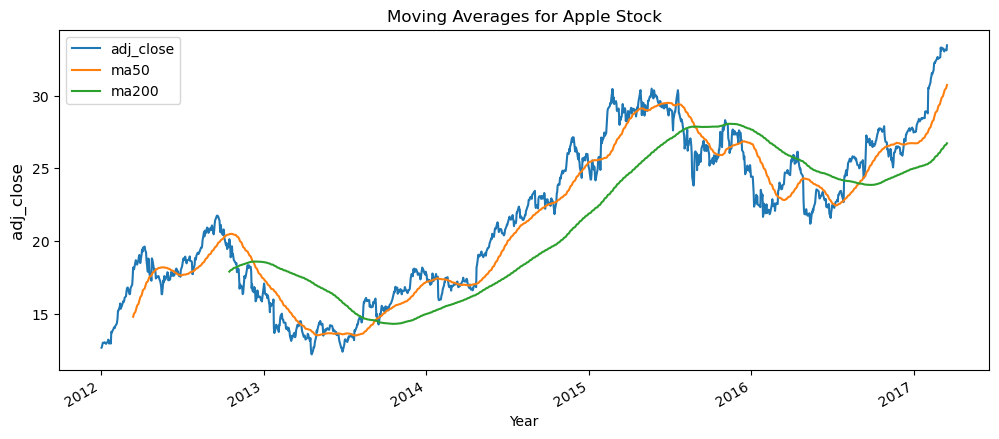

In [43]:
# Calculating the 50-day and 200-day Moving Average for Apple stock:
df_train['ma50'] = df_train['adj_close'].rolling(50).mean()
df_train['ma200'] = df_train['adj_close'].rolling(200).mean()
df_train['adj_close'].plot(figsize = (12,5))
df_train['ma50'].plot()
df_train['ma200'].plot()
plt.xlabel('Year')
plt.ylabel('adj_close', fontsize=12)
plt.title('Moving Averages for Apple Stock')
plt.legend()
plt.show()

Observations:<br>
    - Moving averages have an smoothening effect on adj_close<br>
    - 200 day moving average is smoother than moving average 50<br>
    - Higher moving average has higher lag<br>

### Daily Average Return (DAR) for Apple Stock

The daily average return for a stock is the average gain or loss that a stock has experienced over a given period, usually expressed as a percentage of the stock's price. It is calculated by dividing the total return of a stock over a period of time by the number of trading days in that period.

For example, if a stock had an adjusted close price of $ 100 on Monday and $ 102 on Tuesday, its daily return for Tuesday would be:

(102 - 100) / 100 = 0.02 = 2%

To calculate the average daily return over a period of, say, 30 trading days, you would sum the daily returns for each of the 30 days, then divide the sum by 30.

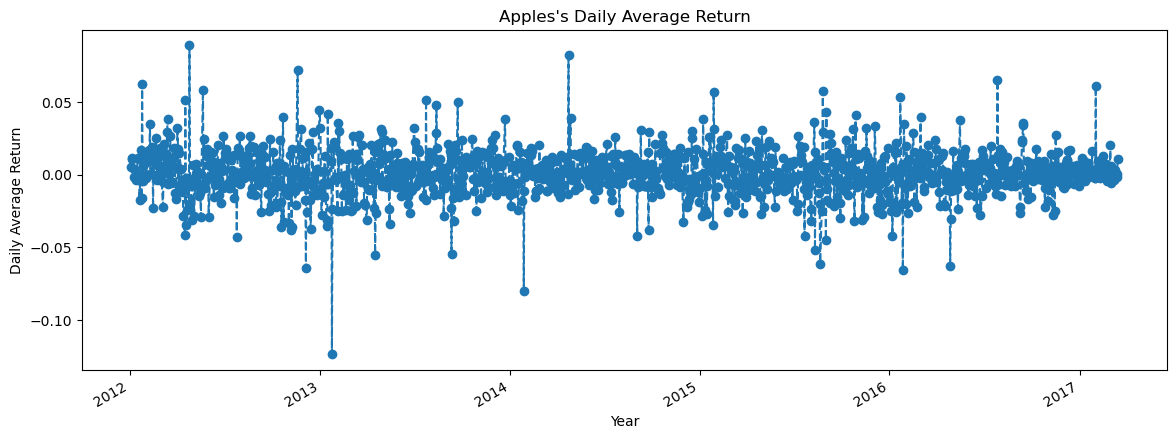

In [44]:
# Calculating the returns for Apple stock using the pct_change() function.pct means percent
df_train['dar'] = df_train['adj_close'].pct_change()
df_train['dar'].plot(figsize=(14,5),linestyle='--',marker='o')
plt.xlabel('Year')
plt.ylabel('Daily Average Return')
plt.title("Apples's Daily Average Return")
plt.show()

Average daila return for Apple stays more or less same with time, with some outliers here and there.

It would be interesting to plot an interective plot of open and close stock price using plotly.

In [45]:
# installed plotly using ----> conda install -c plotly plotly. Alternatively you can also use 'pip install plotly'
# and then 'pip install plotly --upgrade'
import plotly.express as px

In [46]:
fig = px.line(df_train, x=df_train.index, y=["open", "close"], title='Daily open & close for Apple Stocks')
fig.update_layout(title=dict(text="Daily open-close for Apple Stocks",font=dict(size=18)))
fig.show()

### Visualization of Movements of Apple stocks in terms of volume for Weekdays and by Months

For this we have to add Days (Mondays, Tuesdays etc.) and Months (Jan, Feb etc.) to our dataframe df_train. We'll do it below.

In [47]:
# adding a few more columns to our dataset -  year, month name, and weekday name
df_train['year'] = pd.DatetimeIndex(df_train['date']).year
df_train['month'] = pd.DatetimeIndex(df_train['date']).month_name()
df_train['weekday'] = pd.DatetimeIndex(df_train['date']).day_name()  # day_name is a function in pandas

In [48]:
df_train.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  ma50  ma200       dar  year    month    weekday  
date                                                                      
2012-01-03  302220800.0   NaN    NaN       NaN  2012  January    Tuesday  
2012-01-04  260022000.0   NaN    NaN  0.005374  2012  January  Wednesday  
2012-01-05  271269600.0   NaN    NaN  0.011102  2012  January   Thursday  
2012-01-06  318292800.0   NaN    NaN  0.010454  2012  January     Friday  
2012-01-09  394024400.0   NaN    NaN -0.001586  2012  January     Monday

Now let's do the plotting.

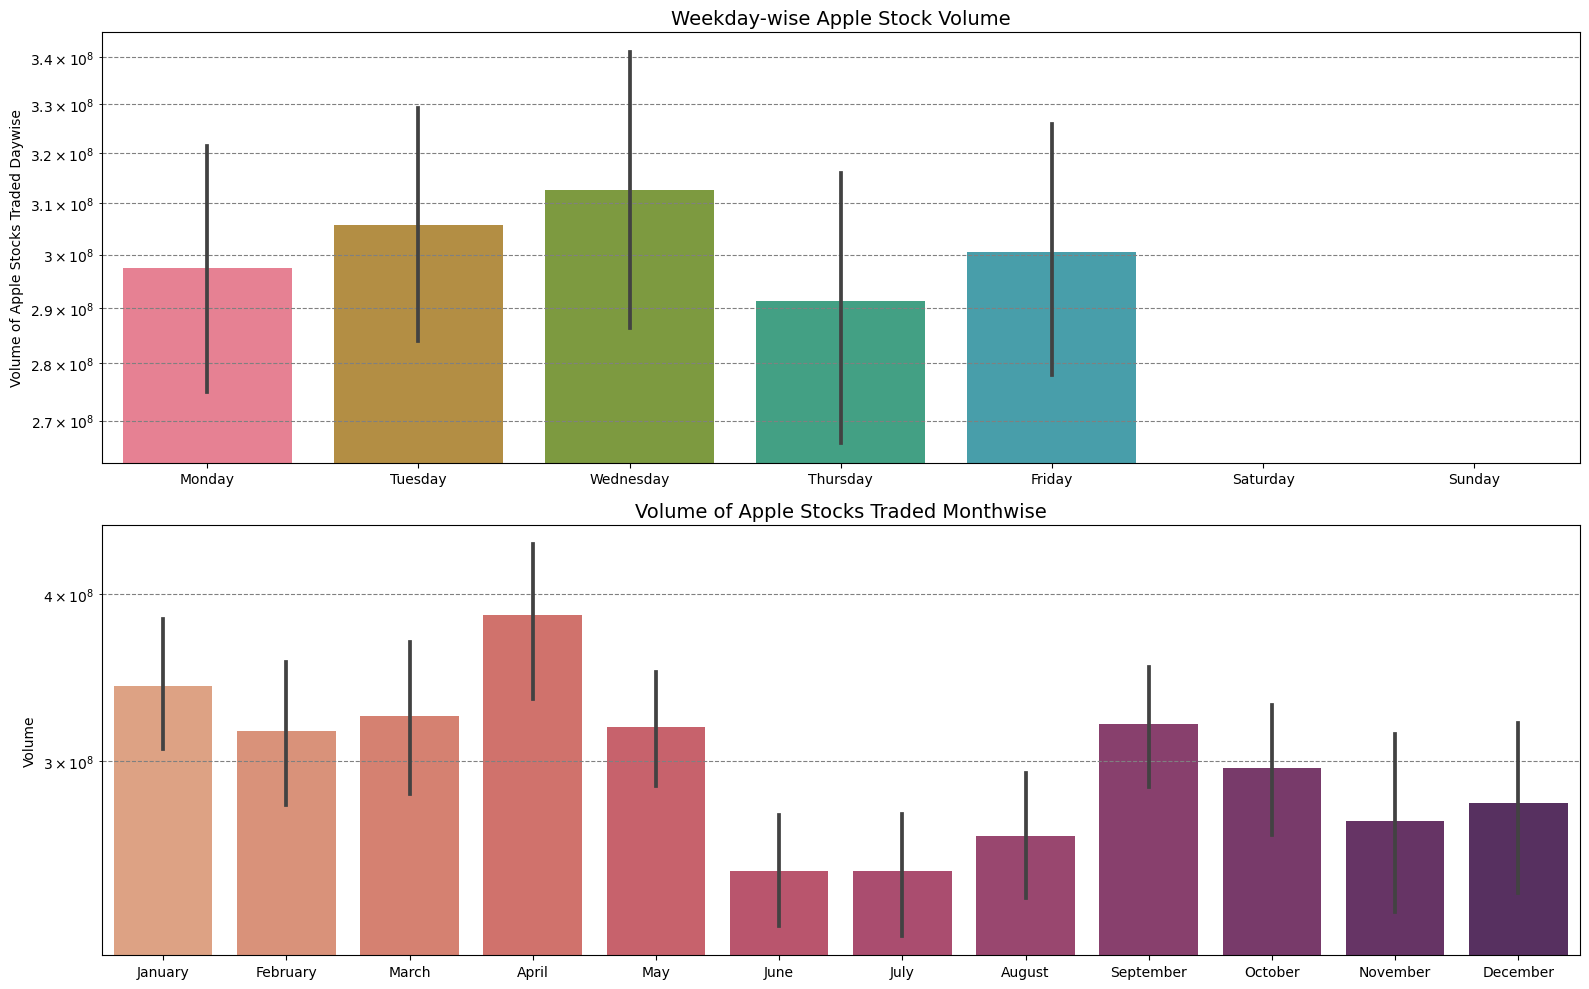

In [49]:
# Visualization of Movements of Apple stocks in terms of volume by Weekdays and by Months 
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# specifying the order of bar plots for weekdays:
order = [ "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
sns.barplot(x=df_train.weekday, y=df_train.volume, palette="husl",ax=axes[0], order =order)
axes[0].set_title("Weekday-wise Apple Stock Volume",fontsize=14)
axes[0].set_yscale("log") 
axes[0].set_ylabel("Volume of Apple Stocks Traded Daywise",fontsize=10)
axes[0].set_xlabel("",fontsize=10)
axes[0].grid(which="minor",color="grey", linestyle="--")

# specifying the order of bar plots for Months:
order2 = [ "January", "February", "March", "April", "May", "June","July", 'August', 'September', 'October', 'November', 'December']
sns.barplot(x=df_train.month, y=df_train.volume, palette="flare",ax=axes[1], order = order2)
axes[1].set_title("Volume of Apple Stocks Traded Monthwise",fontsize=14)
axes[1].set_yscale("log")
axes[1].set_ylabel("Volume",fontsize=10)
axes[1].set_xlabel("",fontsize=10)
axes[1].grid(which="minor",color="grey", linestyle="--")

plt.tight_layout()
plt.show()

Observations:<br>

- Trade volumes of Apple's stocks are highest on Wednesday and Thursday
- There are no trading on Weekends
- Monthwise, highest volume of trading takes place january and october.

### How does mean of Apples's stock on first day of a year trends over years? 

In [50]:
df_train.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  ma50  ma200       dar  year    month    weekday  
date                                                                      
2012-01-03  302220800.0   NaN    NaN       NaN  2012  January    Tuesday  
2012-01-04  260022000.0   NaN    NaN  0.005374  2012  January  Wednesday  
2012-01-05  271269600.0   NaN    NaN  0.011102  2012  January   Thursday  
2012-01-06  318292800.0   NaN    NaN  0.010454  2012  January     Friday  
2012-01-09  394024400.0   NaN    NaN -0.001586  2012  January     Monday

In [51]:
# First, create a copy of train dataset:
df_train_resample_mean = df_train.copy()
df_train_resample_mean.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  ma50  ma200       dar  year    month    weekday  
date                                                                      
2012-01-03  302220800.0   NaN    NaN       NaN  2012  January    Tuesday  
2012-01-04  260022000.0   NaN    NaN  0.005374  2012  January  Wednesday  
2012-01-05  271269600.0   NaN    NaN  0.011102  2012  January   Thursday  
2012-01-06  318292800.0   NaN    NaN  0.010454  2012  January     Friday  
2012-01-09  394024400.0   NaN    NaN -0.001586  2012  January     Monday

In [52]:
df_train_resample_mean.close.resample(rule='AS',label='right').mean()
#df_train_mean_resampled = df_train_mean.close.resample(rule='AS', label='right').mean()

date
2013-01-01    20.573204
2014-01-01    16.879817
2015-01-01    23.066164
2016-01-01    30.010000
2017-01-01    26.151002
2018-01-01    32.324150
Freq: AS-JAN, Name: close, dtype: float64

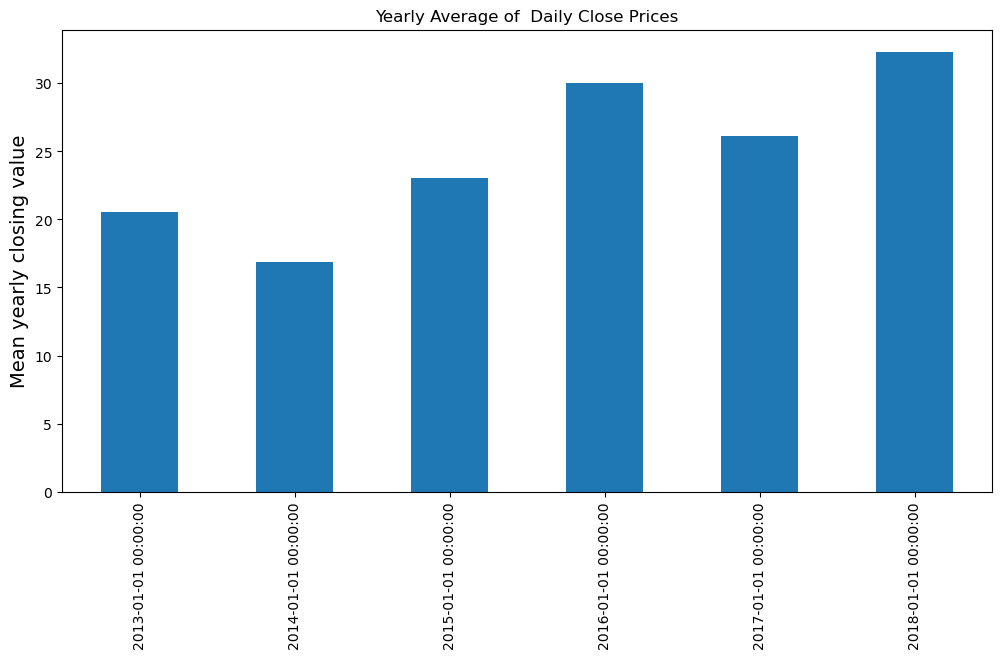

In [53]:
# Plotting a bar for the mean on start of every year 
# Below line will resample the close column of dataframe with AS (annual frequency) and get the yearly mean
ax = df_train_resample_mean.close.resample(rule='AS', label='right').mean().plot.bar(figsize=(12,6))

# setting the title for the plot:
ax.set(title='Yearly Average of  Daily Close Prices')
plt.ylabel('Mean yearly closing value',size=14)
plt.xlabel('')
plt.show()

Observation:
* Yearly average of closing prices fluctuates over years   

### Correlation matrix

In [54]:
df_train_corr = df_train.copy()
df_train_corr.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  ma50  ma200       dar  year    month    weekday  
date                                                                      
2012-01-03  302220800.0   NaN    NaN       NaN  2012  January    Tuesday  
2012-01-04  260022000.0   NaN    NaN  0.005374  2012  January  Wednesday  
2012-01-05  271269600.0   NaN    NaN  0.011102  2012  January   Thursday  
2012-01-06  318292800.0   NaN    NaN  0.010454  2012  January     Friday  
2012-01-09  394024400.0   NaN    NaN -0.001586  2012  January     Monday

In [55]:
df_train_corr = df_train_corr.drop(['ma50','ma200','dar','year','month','weekday'],axis=1)
df_train_corr.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  
date                     
2012-01-03  302220800.0  
2012-01-04  260022000.0  
2012-01-05  271269600.0  
2012-01-06  318292800.0  
2012-01-09  394024400.0

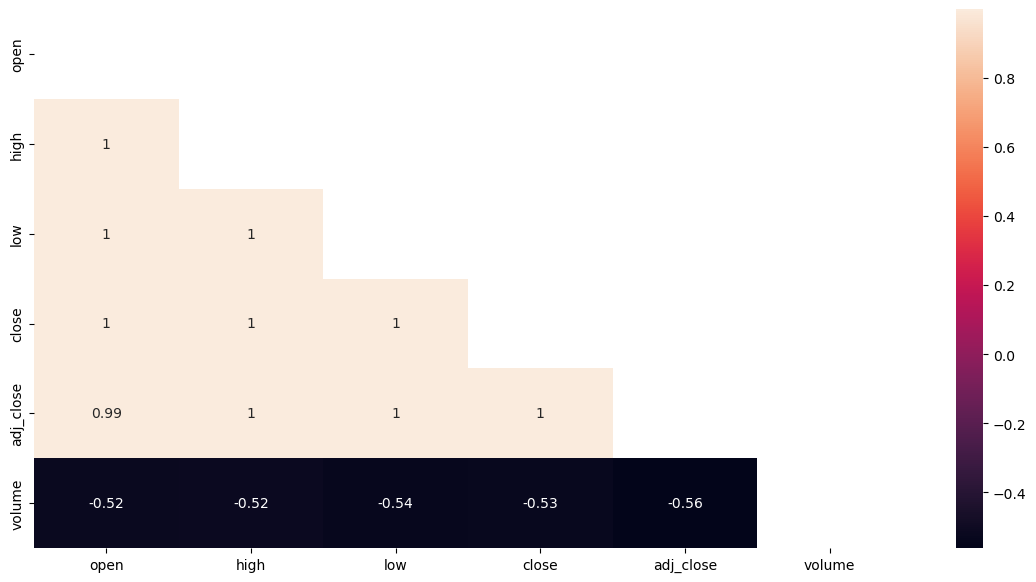

In [56]:
corrM = df_train_corr.corr()

plt.figure(figsize=(14,7))
mask = np.zeros_like(corrM, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corrM[mask] = np.nan
sns.heatmap(corrM, annot=True)
plt.show()

Above correleation matrix plot is not very insightful, as most of them have correlation coefficient of 1. We'll look into how how the differences correlate with volume.

In [57]:
df_train_corr_diff = df_train_corr.copy()
df_train_corr_diff.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  
date                     
2012-01-03  302220800.0  
2012-01-04  260022000.0  
2012-01-05  271269600.0  
2012-01-06  318292800.0  
2012-01-09  394024400.0

In [58]:
# firstly, we crete a copy of the Amazon datasset:
df_train_corr_diff = df_train_corr.copy() 
#df_train_corr_diff.reset_index(inplace=True)

# Feature engineering - adding new columns to the new dataset created:
df_train_corr_diff['open-high'] = df_train_corr_diff['open']-df_train_corr_diff['high']
df_train_corr_diff['open-low'] = df_train_corr_diff['open'] - df_train_corr_diff['low']
df_train_corr_diff['open-close'] = df_train_corr_diff['open'] - df_train_corr_diff['close']
df_train_corr_diff['high-low'] = df_train_corr_diff['high'] - df_train_corr_diff['low']
df_train_corr_diff['high-close'] = df_train_corr_diff['high']-df_train_corr_diff['close']
df_train_corr_diff['close-low'] = df_train_corr_diff['close'] - df_train_corr_diff['low']



# Creating a heatmap to visualize the correlation among different Daily price columns for Amazon stocks:
df_train_corr_diff = df_train_corr_diff.drop(['open','high','low','close', 'adj_close'],axis=1)

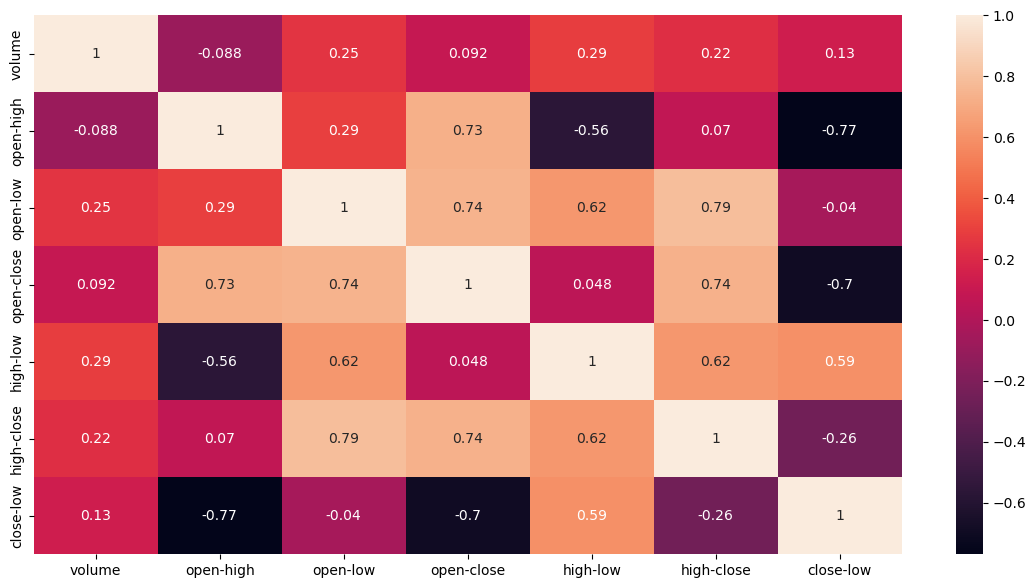

In [59]:
plt.figure(figsize=(14,7))
sns.heatmap(df_train_corr_diff.corr(),annot=True)
plt.show()

Observations:<br>

- it is more useful than the previous heatmap
- highest correlation of volume traded is with high-low. It makes sense because higher is the change in stock price, more activities in the market.

Now we'll do some advanced technical analysis:
- From now on we'll use only date and adjusted close for analysis. <br>

The **adjusted close** is used in stock market analysis as a more accurate representation of the true price of a stock at the end of a trading day. This is because the adjusted close takes into account various corporate actions, such as stock splits, dividends, and rights issues, that can impact the price of a stock.

When a company takes one of these actions, the price of its stock may change, but the change may not reflect the true underlying value of the company or its stock. The adjusted close adjusts the close price of a stock to account for these corporate actions, giving a more accurate representation of the true value of the stock.

For example, consider a stock that has a split, where each share is split into two shares. The number of shares in the market doubles, but the price of each share is halved. The adjusted close adjusts the close price of the stock to account for the split, so that it accurately reflects the true value of the stock before and after the split.

By using the adjusted close in stock market analysis, analysts and investors can better understand the price trends and patterns of a stock over time, and make more informed investment decisions.


Thus from now on, I have only two columns: date and adjusted close.

In [60]:
df_train = df_train.drop(['ma50','ma200','dar','year','month','weekday'],axis=1)
df_train.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  
date                     
2012-01-03  302220800.0  
2012-01-04  260022000.0  
2012-01-05  271269600.0  
2012-01-06  318292800.0  
2012-01-09  394024400.0

### Testing for Stationarity

Time series analysis can be done on a dataset only if it is **stationary**. 

Stationarity is a requirement for time series analysis because a stationary time series is one whose statistical properties such as mean, variance, and autocovariance do not change over time. In other words, the values in a stationary time series are not dependent on the time at which they were recorded.

Time series analysis techniques such as forecasting, decomposition, and hypothesis testing all make assumptions about the statistical properties of the data. When these assumptions are not met, such as when the data is non-stationary, the results of the analysis may be misleading or incorrect. By ensuring that the data is stationary, these assumptions are satisfied and the results of the time series analysis are more reliable. Additionally, many time series models, such as ARIMA, require stationary data in order to be fit correctly.

A non-stationary time series dataset, however, can be made stationary through a process called "differencing". Differencing involves subtracting the value of the time series at a given point in time from the value of the time series at the previous time point. This can help to remove trends and seasonality from the time series and make it more stationary. There are other techniques for making a non-stationary time series stationary as well, including transforming the data (such as taking the log or square root), removing the trend and seasonality through modeling and removing, and using moving averages or exponential smoothing.

It's important to note that the choice of transformation or technique for making a non-stationary time series stationary will depend on the specific properties of the data and the research questions being addressed. It may also be necessary to perform multiple rounds of differencing or transformations in order to achieve stationarity.

**Testing for Stationarity** in a time series can be done using one or more of the following statistical methods:

- Augmented Dicky-Fuller (ADF) Test
- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test


The ***Augmented Dickey-Fuller (ADF) test** is a hypothesis test that tests the null hypothesis that a time series is non-stationary. If the **p-value** of the ADF test is less than a predetermined level of significance (such as 0.05), the null hypothesis is rejected and it is concluded that the time series is stationary.

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test** is a similar hypothesis test that tests the null hypothesis that a time series is stationary. If the p-value of the KPSS test is greater than the level of significance, the null hypothesis is accepted and it is concluded that the time series is non-stationary.

It is also common to visually inspect the time series data, such as by plotting the data and observing if there is any clear **trend** or **seasonality**, or by plotting the **rolling mean** and **standard deviation** to see if they are stable over time. Additionally, the **autocorrelation plot (ACF)** and **partial autocorrelation plot (PACF)** of the time series can provide insight into its stationarity.

In general, it's a good practice to use both statistical tests and visual inspection to determine the stationarity of a time series.

Ref:<br> 
[How to Check if Time Series Data is Stationary](https://machinelearningmastery.com/time-series-data-stationary-python/)

#### Visualization: adjusted close and monthly mean

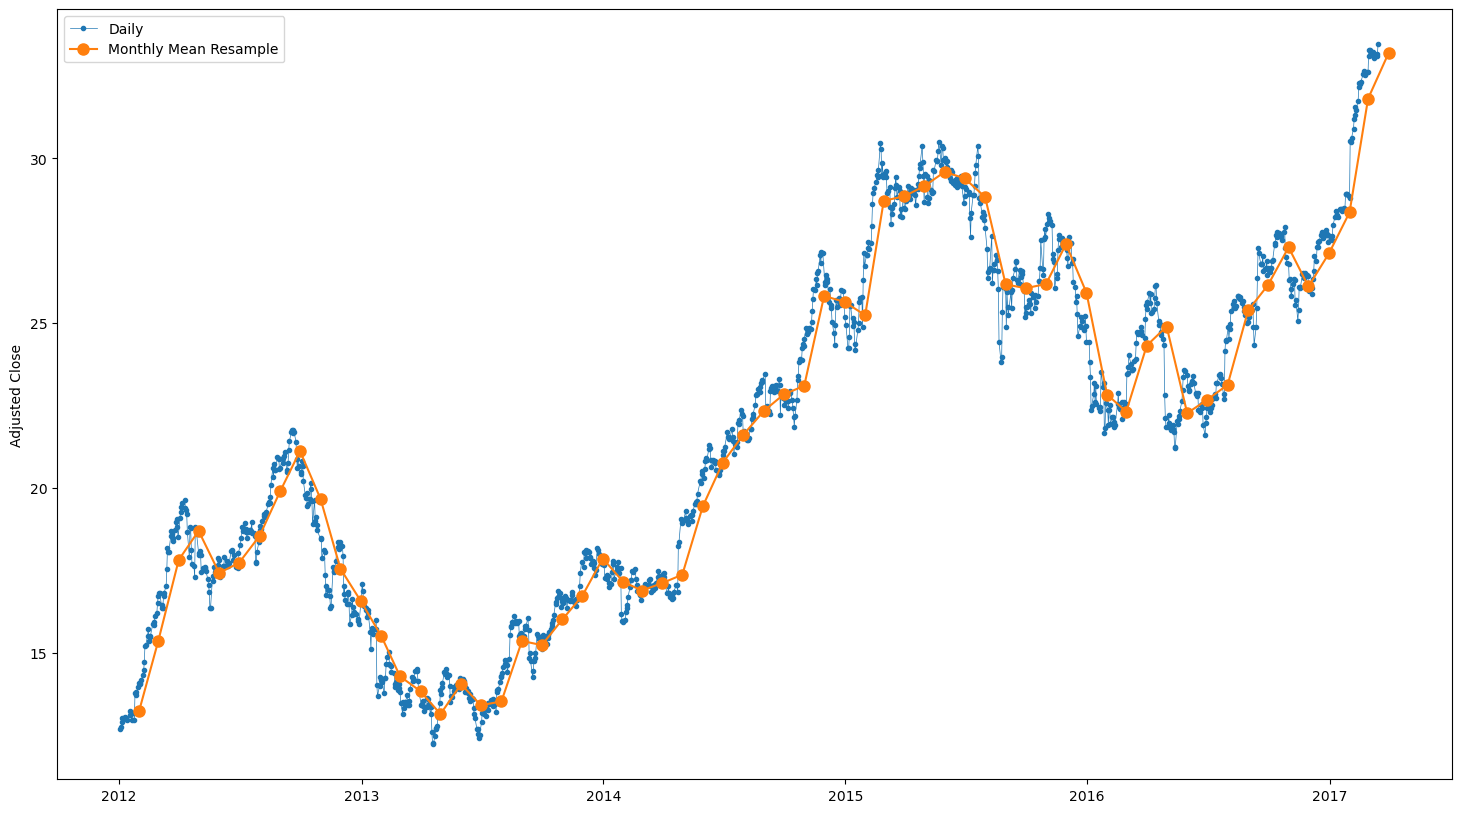

In [61]:
# Visualizing the Daily Adjusted Close and the Monthly Average resampled data
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(df_train['adj_close'],marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df_train['adj_close'].resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Adjusted Close')
ax.legend()
plt.show()

* Both daily and monthly mean follow the same macroscopic trend. 
* no clear trend or seasonality is there.

#### visualization: Rolling or, moving Statistics

Rolling statistics, also known as moving statistics, are calculations of summary statistics that are computed over a rolling window of time in a time series. The rolling window is a fixed-size sliding window that moves through the time series, and the summary statistics are calculated over the data within the window at each position of the window.

In time series analysis, rolling statistics are often used to assess the stability of the mean and variance of a time series over time. For example, the rolling mean and rolling standard deviation of a time series can be computed and plotted over time to visualize how the mean and variance change over time.

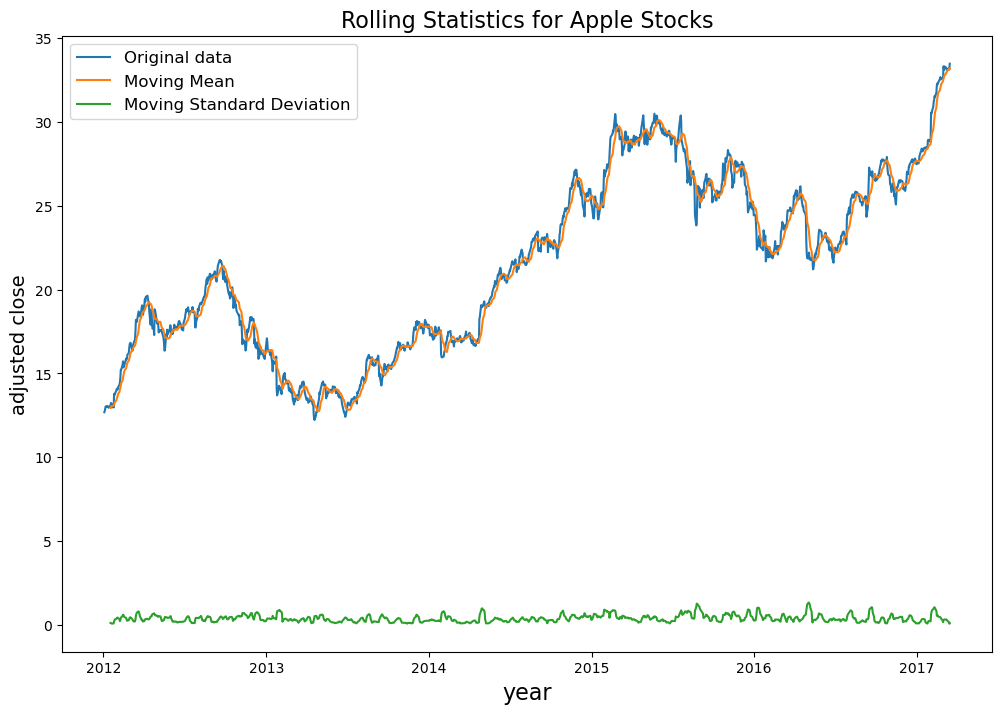

In [62]:
# Determining the moving statistics
df_train_roll = df_train['adj_close']

# calculating the moving mean and standard deviation with window size of 12 days 
roll_mean = df_train_roll.rolling(10).mean() 
roll_std = df_train_roll.rolling(10).std()

# plotting the moving statistics alongwith the original data: 
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_train['adj_close'], label= 'Original data')
ax.plot(roll_mean, label='Moving Mean')
ax.plot(roll_std, label='Moving Standard Deviation')
plt.title('Rolling Statistics for Apple Stocks', fontsize=16)
ax.set_ylabel('adjusted close', fontsize=14)
ax.set_xlabel('year', fontsize=16)
ax.legend(fontsize=12)
plt.show()

**Observations:**<br>

- Mean follows the trend of original data<br>
- Mean clearly doesn't reamin constant and fluctuates with time, suggesting non-stationarity<br>
- Standard deviation remains more or less constant with some noise till about 1999 but then it increases and even has a big jump. So std. dev. is not constant as well, suggesting non-stationarity.<br>
    
**Visual inspection** suggests that our data is not stationary.<br>

To confirm it further, I'll perform ADF test mentioned earlier now.

### ADF Test

To confirm non-stationarity of data, let's perform **ADF test** mentioned earlier. 

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series dataset is stationary. The null hypothesis of the test is that the time series has a unit root (i.e., it is non-stationary), and the alternative hypothesis is that the time series is stationary.

The ADF test works by testing the correlation between the time series and its first differences. If the correlation is low, it indicates that the time series is stationary. The ADF test statistic is calculated as the t-statistic of the estimated coefficient on the first difference term in a regression model. If the calculated ADF test statistic is smaller than the critical value, the null hypothesis can be rejected and the conclusion is that the time series is stationary.

The ADF test is widely used in time series analysis and is a widely accepted method for testing for stationarity. However, it should be noted that the ADF test is a univariate test, meaning that it only considers one time series at a time, and it may not always be appropriate for all datasets.

In [63]:
# Running the adfuller() function on adj_close of Apple stock

#first import adfuller
from statsmodels.tsa.stattools import adfuller


result = adfuller(df_train['adj_close'])

# Printing the test statistic, the p-value and the critical values:
# manually specifying the statistics using a for loop:
output = pd.Series(result[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in result[4].items():
    output['critical value (%s)'%key] =  values
print(output)

# Printing a statement about accepting or rejecting the Null hypothesis by comparing the p-value with the critical values:
if output[1] <= 0.05:
    print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("Weak evidence against null hypothesis, indicating Data is non-stationary.")

Test Statistics                  -0.674824
p-value                           0.853163
No. of lags used                  0.000000
Number of observations used    1307.000000
critical value (1%)              -3.435363
critical value (5%)              -2.863754
critical value (10%)             -2.567949
dtype: float64
Weak evidence against null hypothesis, indicating Data is non-stationary.


ADF test above is performed using the adfuller() function from the statsmodels library. The result object of the ADF test is a tuple with following key elements:

    Zeroth element - Test statistic (the more negative this number is, the more likely that data is stationary)
    Next element - p-value (if p-value < 0.05, we reject the H0 and assume our time series to be stationary)
    Last element - a Python Dictionary with critical values of the test statistic equating to different p-values

Since p value in above test is larger than 0.05, it suggests that our data is **non-stationary**.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test 

Now we'll perform the KPSS test to confirm that our data is non-stationary.

In [64]:
#import kpss function from statsmodels.tsa.stattools
from statsmodels.tsa.stattools import kpss

In [65]:
#write a function for kpss test
def kpss_test(df, significance=0.05):
    result = kpss(df, regression='c')
    p_value = result[1]
    if p_value < significance:
        print(f'Series is NOT Stationary with p-value {p_value}')
    else:
        print(f'Series is  Stationary with p-value {p_value}')

In [66]:
kpss_test(df_train['adj_close'])

Series is NOT Stationary with p-value 0.01


Thus, visualization, ADF and KPSS, all tests have confirmed that our dataset is non-stationary. This means we can't use time series analysis on this dataset. Now, we have to make our data stationary.

There are several methods to make a non-stationary time series stationary, including:

- **Detrending**: It is used to remove the trend component from the time series. Detrending can be performed in various ways, e.g. subtracting the mean or median value from each observation in the time series

- **Differencing**: This involves subtracting the value of each observation from the value of the previous observation. This can be repeated multiple times to achieve stationarity.

- **Transformation**: This involves transforming the data to make it more stationary, such as taking the log or square root of the data.

- **Decomposition**: This involves breaking down the time series into its component parts, such as trend, seasonality, and residuals, and then removing the non-stationary component.

- **Seasonal adjustment**: This involves removing the seasonality component from the data to make it stationary.

- **ARIMA modeling**: This involves modeling the time series using an AutoRegressive Integrated Moving Average (ARIMA) model, which allows for differencing, transformation, and seasonal adjustment to be performed in a single step.

The appropriate method to make a non-stationary time series stationary depends on the specific characteristics of the data. It's best to try different methods and compare the results to determine the best approach.

## Making the Data Stationary

### Detrending
The idea here is to remove the underlying trend in the data by first subtracting moving mean from the data points and then dividing the results of subtraction with moving standard deviation of the data. It makes the data to have mean of zero and standard deviation of 1. 

In [67]:
df_train.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  
date                     
2012-01-03  302220800.0  
2012-01-04  260022000.0  
2012-01-05  271269600.0  
2012-01-06  318292800.0  
2012-01-09  394024400.0

In [68]:
# Detrending the data:
df_train_detrend = df_train.copy()
df_train_detrend['adj_close'] =  (df_train['adj_close'] - \
                                  df_train['adj_close'].rolling(10).mean()) / df_train['adj_close'].rolling(10).std()

In [69]:
df_train_detrend.head(20)

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786        NaN   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715        NaN   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643        NaN   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714        NaN   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786        NaN   
2012-01-10 2012-01-10  15.211071  15.214286  15.053572  15.115714        NaN   
2012-01-11 2012-01-11  15.095715  15.101786  14.975357  15.091071        NaN   
2012-01-12 2012-01-12  15.081429  15.103572  14.955358  15.049643        NaN   
2012-01-13 2012-01-13  14.989285  15.016071  14.952143  14.993215        NaN   
2012-01-17 2012-01-17  15.150000  15.213928  15.105714  15.167857   1.104424   
2012-01-18 2012-01-18  15.248571  15.338214  15.225000  15.325357   1.812782   
2012-01-19 2012-01-19  15.362500  15.406072  15.232500  15.276786   1.386918   
2012-01-20 2012-01-20  15.267500  15.267858  14.991072  15.010715  -0.980239   
2012-01-23 2012-01-23  15.095357  15.301785  15.082143  15.264643   1.095551   
2012-01-24 2012-01-24  15.182143  15.182143  14.983929  15.014643  -0.954424   
2012-01-25 2012-01-25  16.230000  16.230356  15.847500  15.952143   2.575890   
2012-01-26 2012-01-26  16.012857  16.028214  15.826428  15.879642   1.674674   
2012-01-27 2012-01-27  15.869286  16.017143  15.848928  15.974286   1.480578   
2012-01-30 2012-01-30  15.918214  16.210714  15.906786  16.178928   1.527167   
2012-01-31 2012-01-31  16.271070  16.365715  16.181072  16.302856   1.401049   

                 volume  
date                     
2012-01-03  302220800.0  
2012-01-04  260022000.0  
2012-01-05  271269600.0  
2012-01-06  318292800.0  
2012-01-09  394024400.0  
2012-01-10  258196400.0  
2012-01-11  215084800.0  
2012-01-12  212587200.0  
2012-01-13  226021600.0  
2012-01-17  242897200.0  
2012-01-18  276791200.0  
2012-01-19  261738400.0  
2012-01-20  413974400.0  
2012-01-23  306062400.0  
2012-01-24  547638000.0  
2012-01-25  958314000.0  
2012-01-26  323985200.0  
2012-01-27  299709200.0  
2012-01-30  379341200.0  
2012-01-31  391683600.0

In [70]:
# function for performing adf test
def adf_test(df, significance=0.05):
    adf_result = adfuller(df['adj_close'].dropna())
    output = pd.Series(adf_result[0:4], index=['Test Statistics', 'p-value', 'No. of Lags Used',\
                                               'Number of Observations Used'])
    for key, value in result[4].items():
        output['Critical Value (%s)' % key] = value
    if output['p-value'] <= significance:
        print('Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.')
    else:
        print('Weak evidence against the null hypothesis (Ho), indicating data is non-stationary.')
    return output

In [71]:
adf_test(df_train_detrend)

Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.


Test Statistics               -1.308677e+01
p-value                        1.822986e-24
No. of Lags Used               0.000000e+00
Number of Observations Used    1.298000e+03
Critical Value (1%)           -3.435363e+00
Critical Value (5%)           -2.863754e+00
Critical Value (10%)          -2.567949e+00
dtype: float64

We already see from the ADF test that our dataset after detrend is stationary. We'll visualize the rolling statistics now.

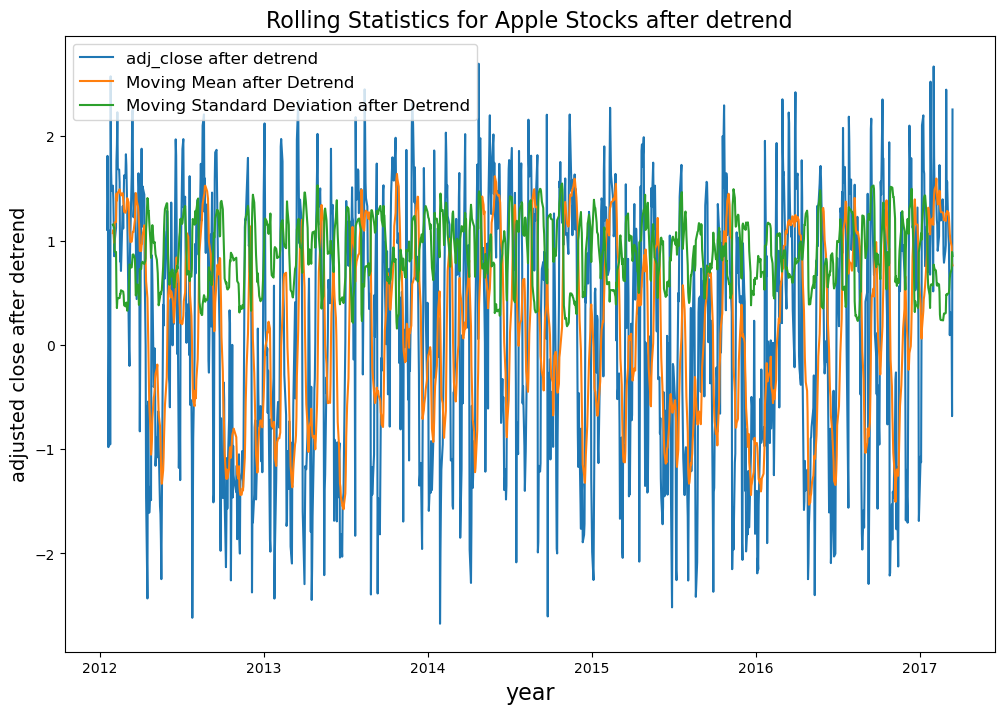

In [72]:
# Determining the moving statistics
df_train_detrend_roll = df_train_detrend['adj_close']

# calculating the moving mean and standard deviation with window size of 12 days 
roll_mean = df_train_detrend_roll.rolling(10).mean() 
roll_std = df_train_detrend_roll.rolling(10).std()

# plotting the moving statistics alongwith the original data: 
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_train_detrend['adj_close'], label= 'adj_close after detrend')
ax.plot(roll_mean, label='Moving Mean after Detrend')
ax.plot(roll_std, label='Moving Standard Deviation after Detrend')
plt.title('Rolling Statistics for Apple Stocks after detrend', fontsize=16)
ax.set_ylabel('adjusted close after detrend', fontsize=14)
ax.set_xlabel('year', fontsize=16)
ax.legend(fontsize=12)
plt.show()

**Observations:**<br>
* adjusted close after detrend has zero mean<br>
* moving mean after detrend is averaged at zero<br>
* moving std. dev. after detrend is averaged around 1<br>

### Differencing

Another common method used for stationarizing a time-series is **differencing**. It involves subtracting the value of a time series at a particular time step with its value at a previous time step. The resulting difference series is used instead of the original time series for further analysis.

The purpose of differencing is to remove the trend and seasonality from a time series.

Differencing can be performed multiple times to remove higher-order trends and seasonality. For example, the difference of a difference series (known as second-order differencing) can be taken to remove second-order trends.

One has to be careful not to over-difference a time series, because, an over-differenced series may still be stationary but would affect the model parameters.

Therefoe, **Optimal order for Differencing** is defined as minimum differencing order required to get a near-stationary series with a defined mean and for which the **ACF** plot quickly reaches zero.

In [73]:
## First Order of Differencing -
# Taking the first order difference of Apple stock data by  dropping the NaN
# Calculating the first difference of the time series:
df_train_diff = df_train.copy()
df_train_diff['adj_close'] = df_train['adj_close'].diff().dropna()

In [74]:
adf_test(df_train_diff)

Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.


Test Statistics                 -35.468637
p-value                           0.000000
No. of Lags Used                  0.000000
Number of Observations Used    1306.000000
Critical Value (1%)              -3.435363
Critical Value (5%)              -2.863754
Critical Value (10%)             -2.567949
dtype: float64

## ACF and PACF Plots

Now we'll look at the ACF and PACF plots.

**ACF** and **PACF** are plots used in time series analysis to understand the **autocorrelation structure** of a time series.

ACF (Auto-Correlation Function) plot shows the correlation between the time series and its lagged (delayed) values. The plot shows the correlation between the time series and lagged values of itself, where a strong positive correlation indicates a strong relationship between the series and its lagged values.

PACF (Partial Auto-Correlation Function) plot shows the direct relationship between a time series and its lagged values, after controlling for the relationship between the time series and all its intermediate lagged values. The plot shows the correlation between the time series and each of its lagged values, after controlling for the influence of all other lagged values.

Both ACF and PACF plots are used:<br>

* to identify the appropriate order of differencing and the number of autoregressive (AR) and moving average (MA) terms in time series models such as ARIMA. 
* to determine the presence of autocorrelation and partial autocorrelation, which can be used to make informed decisions about modeling the time series.

A complete zero Autocorrelation on ACF means that there is no significant autocorrelation between lagged values of the series, This means that the value of the time series at any point in time is not significantly related to its value at prior time points. In other words, the presence of a trend or seasonality in the time series is not strong enough to produce a non-zero ACF. This information can be useful in identifying the appropriate time series model to use for forecasting, as it suggests that a simple model such as a random walk or white noise model might be appropriate, rather than a more complex model that assumes a strong autocorrelation.

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

width = 12
height = 4

# write a function for plotting ACF and PACF
def plot_acf_pacf(df, column, figsize=(width, 3*height), title=None):
    ts = df[column].dropna()
    
    fig = plt.figure(figsize=figsize)
    if title:
        fig.suptitle(title, fontsize=16, y=1)
    
    ax1 = fig.add_subplot(311)
    ax1.plot(ts)
    ax1.set_title('Adjusted Close of Time Series')

    # Plot the autocorrelation function ACF
    ax2 = fig.add_subplot(312)
    fig = plot_acf(ts, lags=40, ax=ax2)
    ax2.set_title('Autocorrelation Function (ACF)')

    # Plot the partial autocorrelation function
    ax3 = fig.add_subplot(313)
    fig = plot_pacf(ts, lags=40, method = 'ywm', ax=ax3)
    ax3.set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

### On originial train data i.e. before differencing or detrending

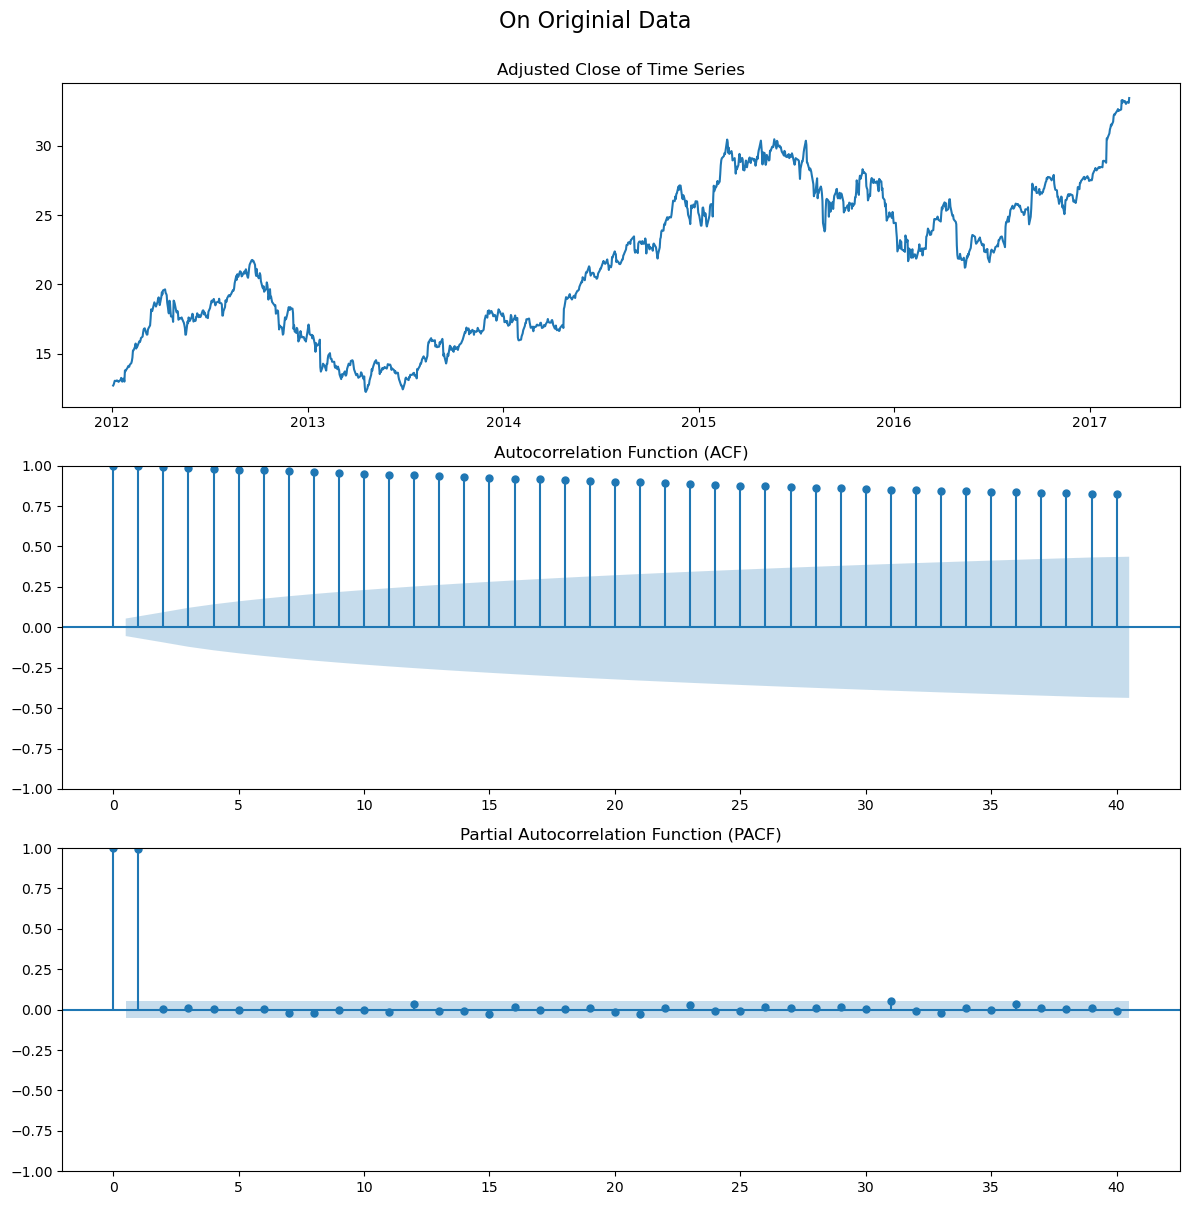

In [76]:
plot_acf_pacf(df_train, 'adj_close', title='On Originial Data')

**Observations:**<br>

**ACF**<br>
* ACF is 1 at the first lag and then decreases very slowly.

* It indicates that there is a strong positive correlation between the observation and its first lag, and the correlation gradually decreases as the lag increases. Thus, there may be a slowly-decaying relationship between the observations, possibly due to a slow-moving underlying trend or seasonality in the data.   

* The shaded part in the ACF plot represents the confidence interval of the sample autocorrelation. It provides a visual indication of the uncertainty around the estimated autocorrelation values.

Typically, the shaded region is calculated based on the assumption that the underlying time series is a random process, and it is constructed as a function of the sample size and the level of significance (often set to 0.05). If the autocorrelation values outside the shaded region are significantly different from zero, it suggests that there is a meaningful relationship between the observation and its lagged values.

The shaded part in an ACF plot can be useful in guiding the interpretation of the plot, as it provides a way to assess the statistical significance of the estimated autocorrelations. However, it's important to remember that the shaded region is based on assumptions about the underlying process and the sample size, and it may not always be an accurate reflection of the true uncertainty in the autocorrelation estimates.

**PACF**<br>

* PACF is close to 1 for the first maybe 2 lags, but then close to zero for higher lags. It suggests that the first 2 lags have a strong relationship with the current observation, while the higher lags have little to no relationship. This pattern often indicates an AR(2) model, where the current observation is a linear combination of the 2 previous observations. In other words, the first 2 lags are the significant lags in the time series.

* It's important to note that the interpretation of PACF plots can be influenced by the stationarity of the time series, and it's recommended to check the stationarity of the data before analyzing the PACF plot. Additionally, the choice of which lags to include in a time series model should also be guided by other methods, such as the Akaike information criterion (AIC) or Bayesian information criterion (BIC).



We need to keep in mind that ACF and PACF for non-stationary data may be misleading and our original data, as lready seen previously, is non-stationary. However these plots are made as an exercise and how does it look and what can be interpreted.

### On train data after detrending

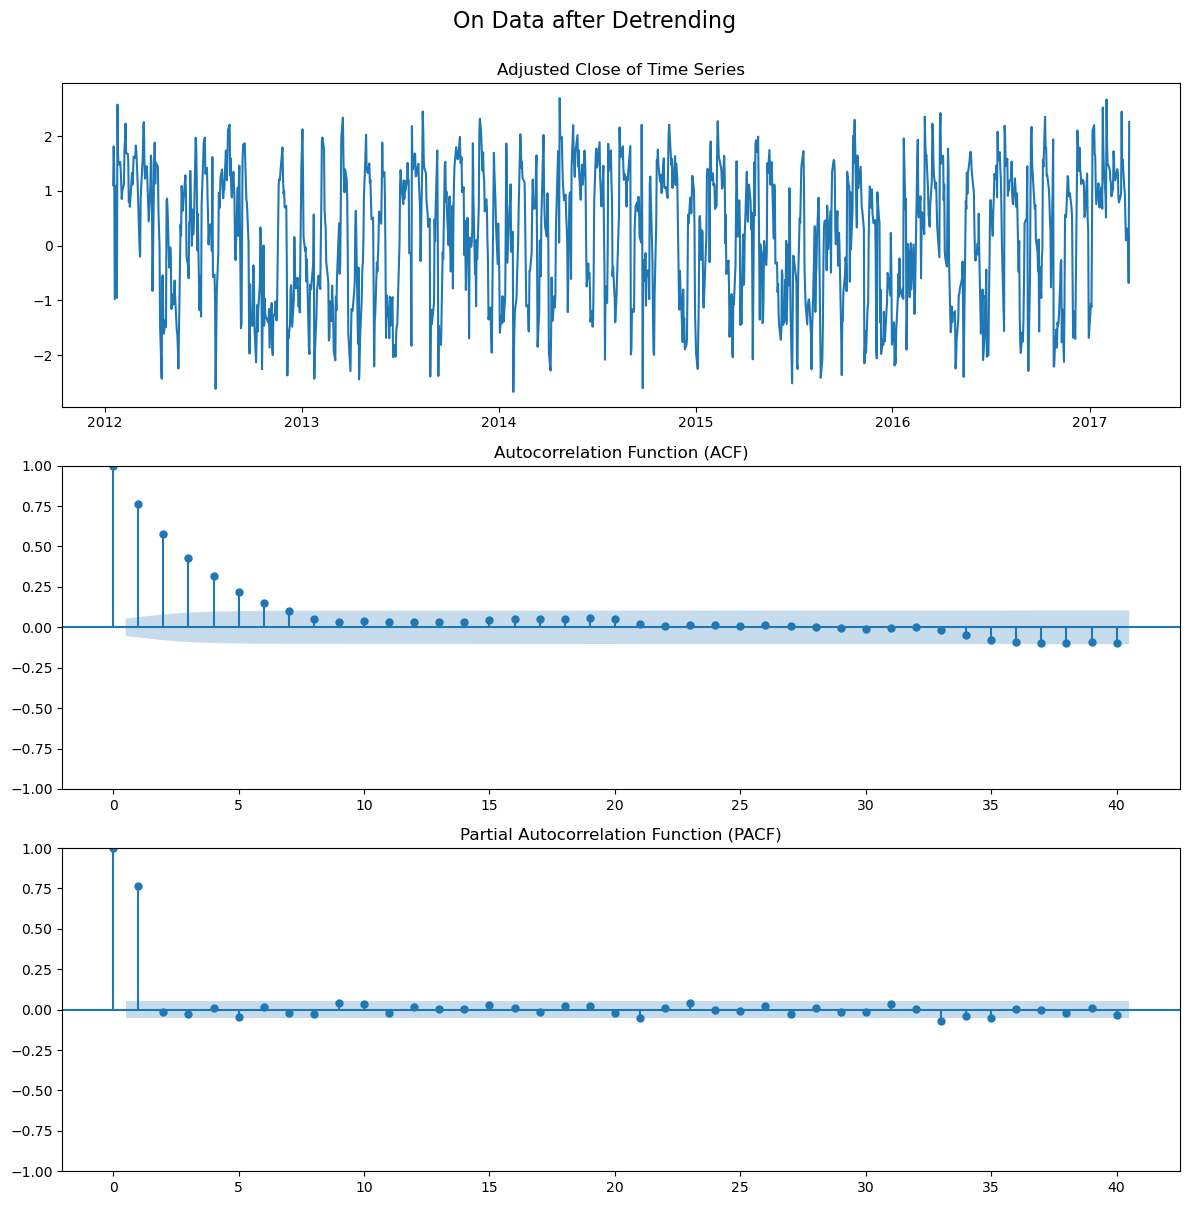

In [77]:
plot_acf_pacf(df_train_detrend, 'adj_close', title='On Data after Detrending')

**Observations**<br>

* ACF and PACF decreases rapidly compared to original data

### On dataset after differencing

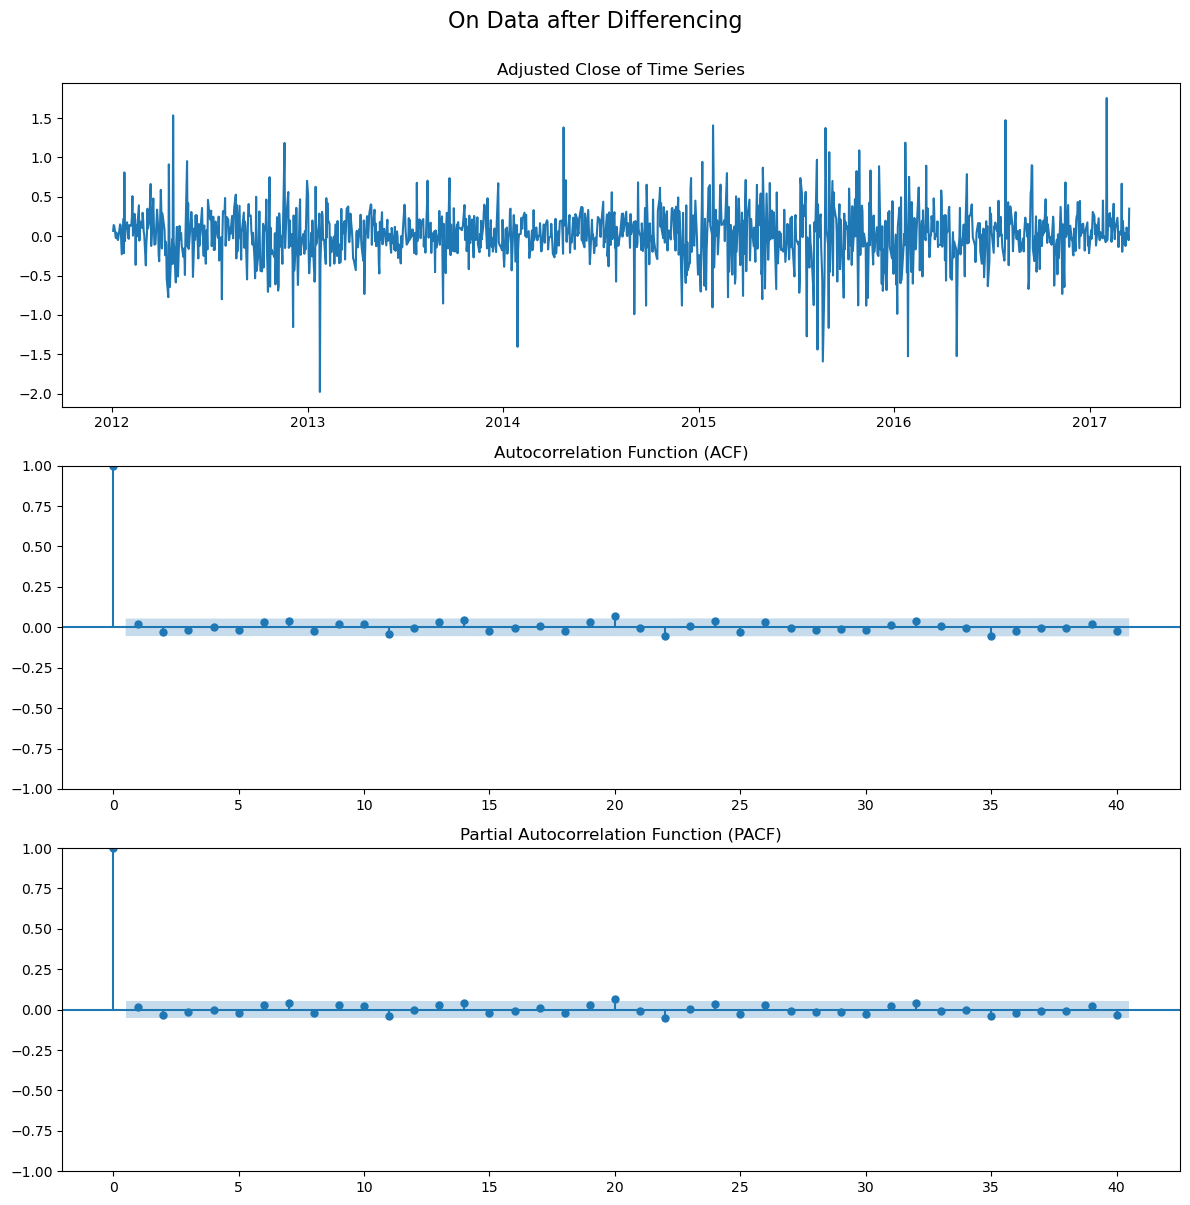

In [78]:
plot_acf_pacf(df_train_diff, 'adj_close', title='On Data after Differencing')

**Observations**:<br>

**ACF**<br>
* ACF is 1 for first lag, but then zero afterwards
* * A zero autocorrelation means that the value of the time series at any time step is not related to its value at any previous time step.

**PACF**
* PACF is 1 for first lag, but then zero afterwards
* a PACF plot that is zero, except for one jump at zero, suggests that the time series is likely to be an autoregressive time series with a strong dependence on its past value, and an AR(1) model may be a suitable choice for modeling the time series.

# 1. Seasonal ARIMA (SARIMA) model

In [79]:
df_train.head()

date       open       high        low      close  adj_close  \
date                                                                           
2012-01-03 2012-01-03  14.621428  14.732142  14.607142  14.686786  12.691425   
2012-01-04 2012-01-04  14.642858  14.810000  14.617143  14.765715  12.759631   
2012-01-05 2012-01-05  14.819643  14.948215  14.738214  14.929643  12.901293   
2012-01-06 2012-01-06  14.991786  15.098214  14.972143  15.085714  13.036158   
2012-01-09 2012-01-09  15.196428  15.276786  15.048214  15.061786  13.015480   

                 volume  
date                     
2012-01-03  302220800.0  
2012-01-04  260022000.0  
2012-01-05  271269600.0  
2012-01-06  318292800.0  
2012-01-09  394024400.0

We'll use only the date and adj_close column for this training.

In [80]:
drop_Features = ['open', 'high','low','close','volume']
df_train_dropped = df_train.drop(axis=1,labels=drop_Features)
df_full_train_dropped = df_full_train.drop(axis=1,labels=drop_Features)
df_val_dropped = df_val.drop(axis=1,labels=drop_Features)
df_test_dropped = df_test.drop(axis=1,labels=drop_Features)
df_train_dropped.head()

date  adj_close
date                            
2012-01-03 2012-01-03  12.691425
2012-01-04 2012-01-04  12.759631
2012-01-05 2012-01-05  12.901293
2012-01-06 2012-01-06  13.036158
2012-01-09 2012-01-09  13.015480

In [81]:
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
df_train_dropped_mean = df_train_dropped['adj_close'].resample('M').mean()
df_full_train_dropped_mean = df_full_train_dropped['adj_close'].resample('M').mean()
df_val_dropped_mean = df_val_dropped['adj_close'].resample('M').mean()
df_test_dropped_mean = df_test_dropped['adj_close'].resample('M').mean()
df_train_dropped_mean.head()

date
2012-01-31    13.226823
2012-02-29    15.356091
2012-03-31    17.823108
2012-04-30    18.702534
2012-05-31    17.427008
Freq: M, Name: adj_close, dtype: float64

In [82]:
#convert series object to a dataframe with a single columns
df_train_dropped_mean = df_train_dropped_mean.to_frame()
df_full_train_dropped_mean = df_full_train_dropped_mean.to_frame()
df_val_dropped_mean = df_val_dropped_mean.to_frame()
df_test_dropped_mean = df_test_dropped_mean.to_frame()
df_train_dropped_mean.head

adj_close
date                 
2012-01-31  13.226823
2012-02-29  15.356091
2012-03-31  17.823108
2012-04-30  18.702534
2012-05-31  17.427008
...               ...
2016-11-30  26.113484
2016-12-31  27.118104
2017-01-31  28.359570
2017-02-28  31.809563
2017-03-31  33.194495

[63 rows x 1 columns]

In [83]:
df_train_dropped_mean.head(2)

adj_close
date                 
2012-01-31  13.226823
2012-02-29  15.356091

In [85]:
len(df_train_dropped_mean), len(df_val_dropped_mean)

(63, 22)

Carrying out Grid Search to Select Parameters especially for Seasonal Component of the Time Series .

Parameters for Series already indicate Non-Seasonality Part with Order (1,1,1).

AR(1) derived by the PACF plot

MA(1) derived by the ACF Plot

Differencing(1) derived by differencing and observing stationarity.

## Hyper Parameter Tuning for Model Order

In [86]:
import statsmodels.api as sm

In [89]:
#create an instance of SARIMA model
model = sm.tsa.statespace.SARIMAX(df_full_train_dropped_mean['adj_close'], order=(1,1,1), seasonal_order=(2,2,0,12), \
                                   enforce_stationarity=False, enforce_invertibility=False)


In [90]:
# fit model to the data using fit method
model_fit = model.fit(disp=0)

In [91]:
# use model_fit object to make predictions using predict method
prediction_test = model_fit.predict(start='2012-09-30',end='2020-09-30')

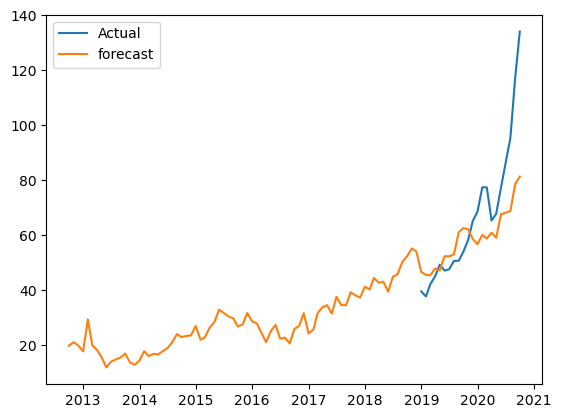

In [92]:
# Plot the DataFrame column and the Series in one plot
plt.plot(df_test_dropped_mean['adj_close'], label='Actual')
plt.plot(prediction_test, label='forecast')
plt.legend()
plt.show()

## Hyperparameter tuning for SARIMA model

In [93]:
p = d = q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [94]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [95]:
param = (1,1,1)
list_param_seasonal=[]
list_results_aic=[]


for param_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(full_train,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
        results = model.fit(disp=0)
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        list_param.append(param)
        list_param_seasonal.append(param_seasonal)
        list_results_aic.append(results.aic)
    except:
        continue

So lowest AIC value we get is: ARIMA(1, 1, 1)x(0, 2, 2, 12)12 - AIC:173.51553289161185,
i.e. seasonal order (0,2,2,12)

Let's train now after hyperparameter tuning.

## Back-Testing Training and Testing Data

    Since we cannot use cross validation in our time series based datasets,as it can jumble the datasets during different folds.

    This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups.

We can use backtesting method for time series.

    In backtesting we can create multiple train-test splits keeping in mind the temporal order of our data during splits . For example if I have dataset between Jan to Dec

Split - 1 : Train Data (Jan to Aug) + Test Data (Aug to Dec)

Split - 2 : Train Data (Jan to Sept) + Test Data (Sept to Dec)

Split - 3 : Train Daata (Jan to Oct) + Test Data (Oct to Dec) and so on ... We can have multiple splits in our dataset to validate our model rather than just one split like traditional train test splits .

ref: [https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

In [96]:
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit

In [97]:
from matplotlib.patches import Patch

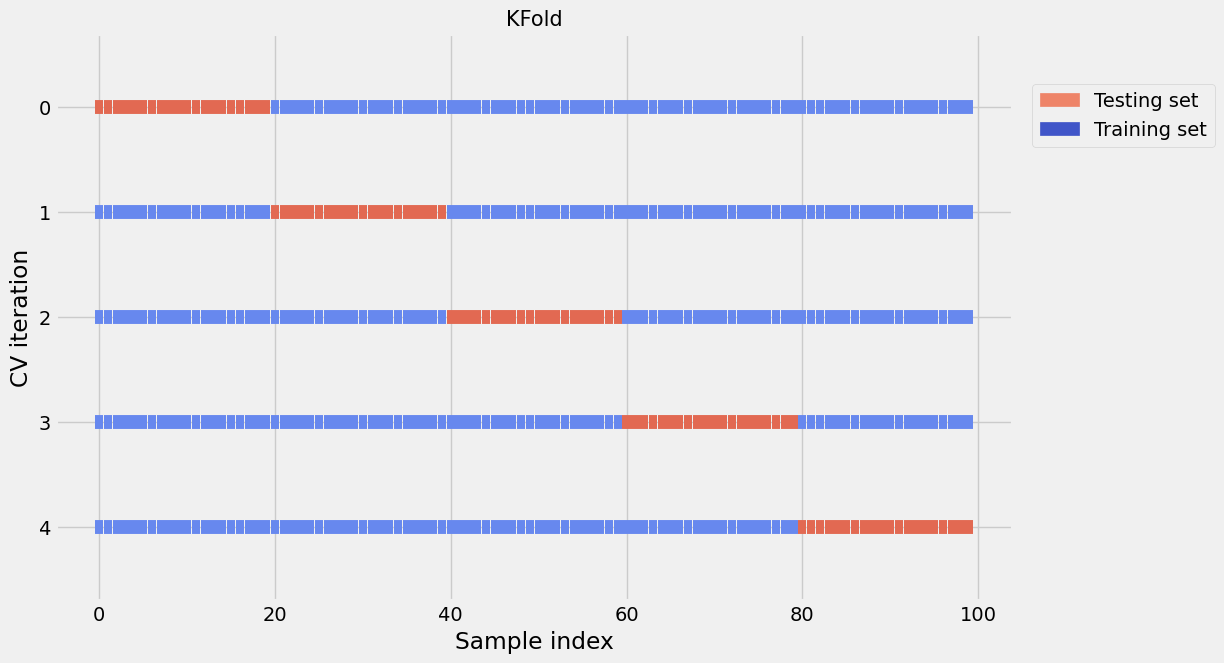

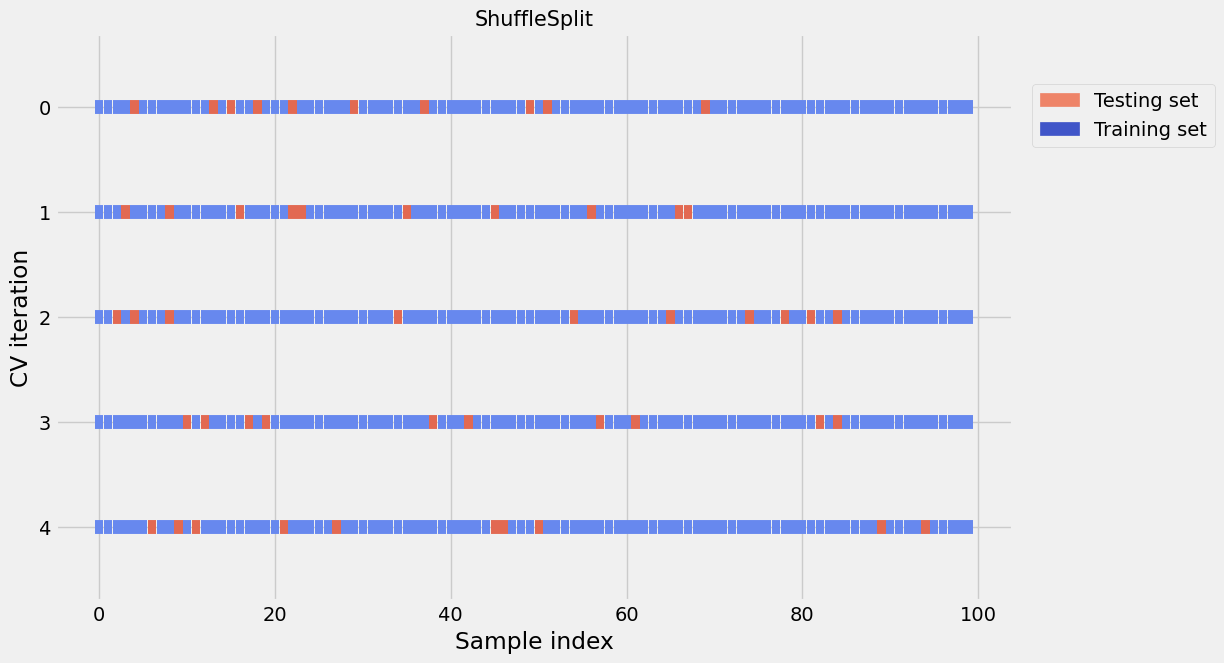

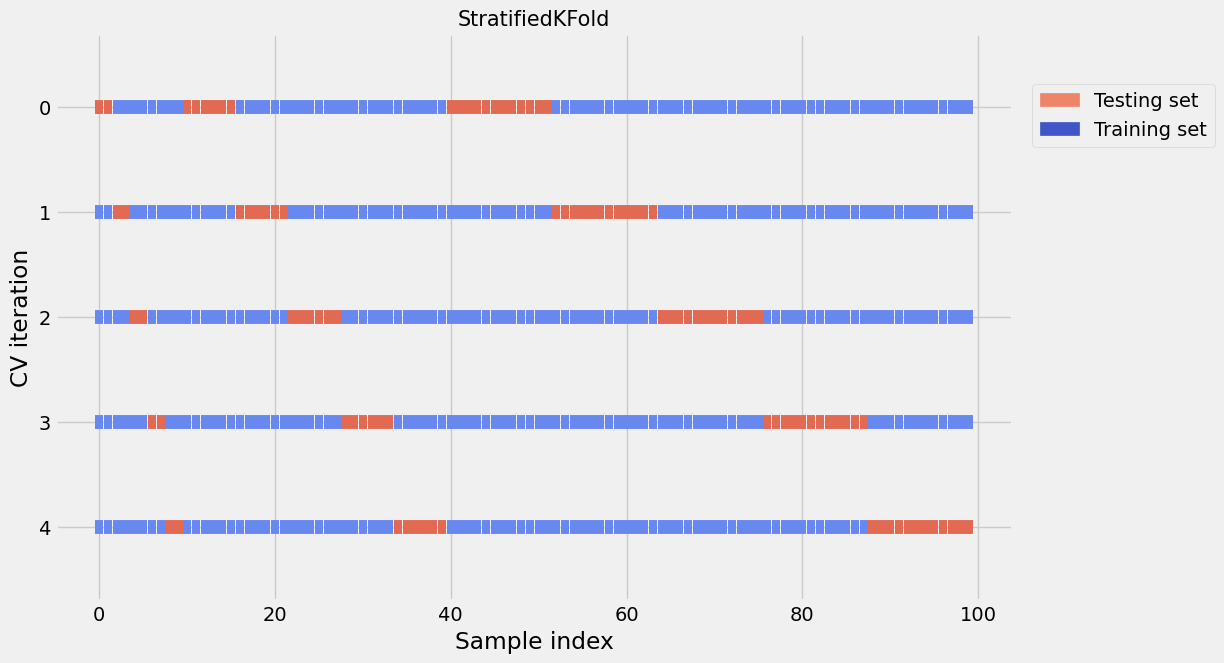

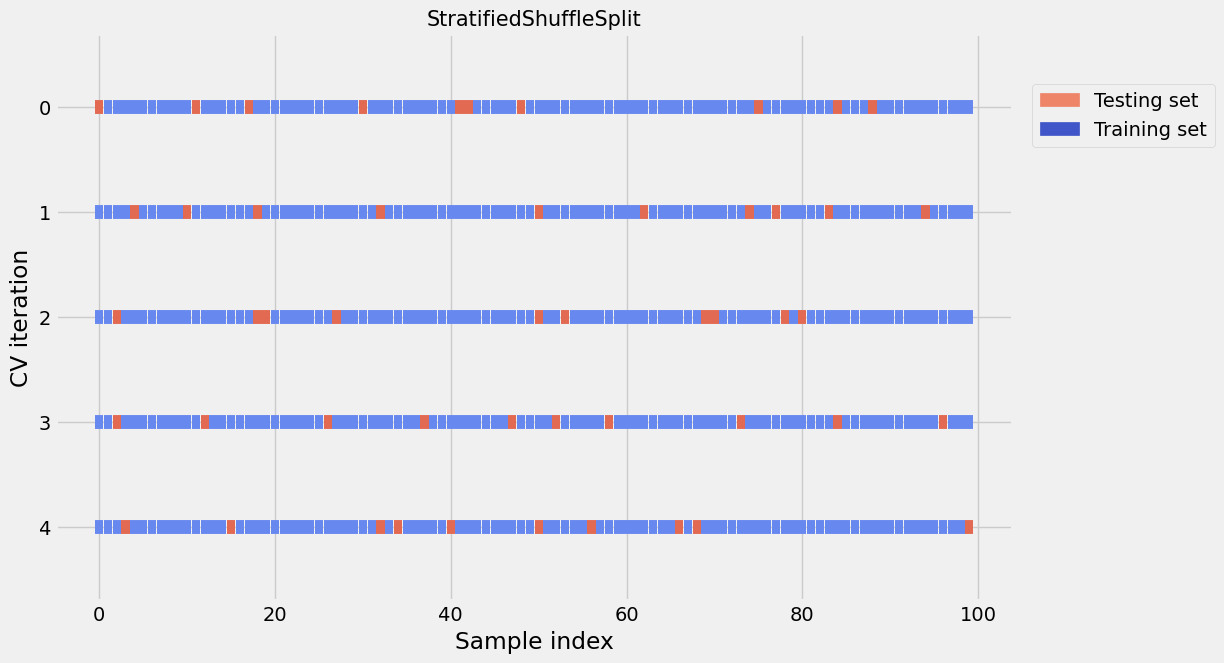

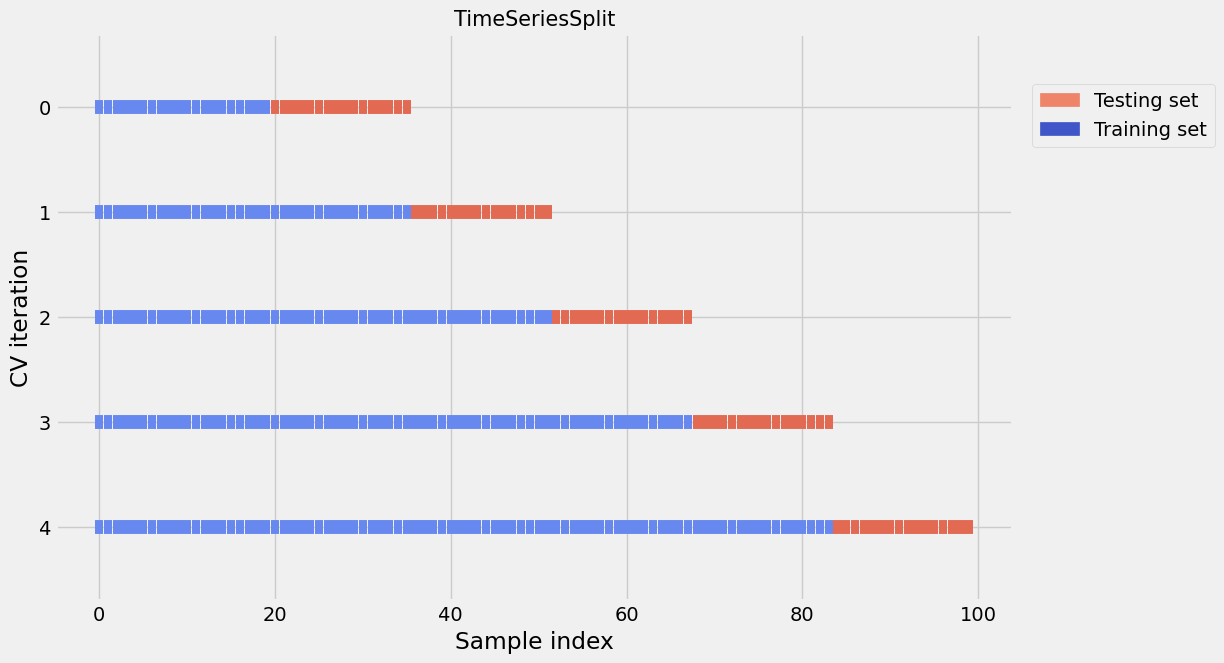

In [98]:
## Using TimeSeriesSplit from sklearn library
## Citation : https://www.kaggle.com/tomwarrens/timeseriessplit-how-to-use-it

pd.options.display.max_columns = 30
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

warnings.filterwarnings('ignore')

cvs = [KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit]
n_points = 100
n_splits = 5

X = np.random.randn(100, 10)
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Function modified from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html


# create function to plot training and testing indices in the CV strategies
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
    #yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
        
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=list(range(n_splits+2)),
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
for i, cv in enumerate(cvs):
    this_cv = cv(n_splits=n_splits)
    plot_cv_indices(this_cv, n_splits, X, y, date_col=None)

After looking at how different cross validation mechanism works, we'll now use TimeSeriesSplit for our time series dataset. In time series, evaluating models on past data is called **Backtesting**. In some area such as meteorology, the word **hindcasting** is used for the same.

## Use TimeSeriesSplit to split the data and Backtesting

In [99]:
from matplotlib import pyplot

In [101]:
train_list = {}
test_list = {}
time_series_splits = TimeSeriesSplit(n_splits=5)
X = df_full_train_dropped_mean['adj_close'].values

index = 1
for train_index, test_index in time_series_splits.split(X):
    full_train_split = X[train_index]
    test_split = X[test_index]
    train_list[index] = full_train_split
    test_list[index] = test_split
    index += 1

In [102]:
full_train_split

array([13.226823  , 15.35609145, 17.82310832, 18.7025342 , 17.42700818,
       17.73220914, 18.55023329, 19.8988393 , 21.12495295, 19.6727251 ,
       17.55578876, 16.56615825, 15.50028533, 14.28887747, 13.8374137 ,
       13.14604545, 14.04878009, 13.41505535, 13.52915264, 15.363643  ,
       15.23773405, 16.01710704, 16.7303306 , 17.86335062, 17.15438329,
       16.89286132, 17.12119814, 17.37357886, 19.45106057, 20.76806781,
       21.61349186, 22.33901014, 22.83916167, 23.10060174, 25.82687816,
       25.64445955, 25.2406985 , 28.71090958, 28.85122114, 29.15366119,
       29.58921515, 29.39397123, 28.82558864, 26.1801501 , 26.05946838,
       26.18939518, 27.3976763 , 25.92257086, 22.83723332, 22.31731975,
       24.32309877, 24.89970481, 22.2711249 , 22.67693136, 23.1308895 ,
       25.38807483, 26.15875276, 27.30319781, 26.1134841 , 27.11810443,
       28.3595704 , 31.80956326, 33.49628461, 34.03678342, 36.35803764,
       35.35995777, 35.47193295, 38.14097643, 37.84660555, 37.89

In [103]:
def backtest_model(train,test):
    model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
    results=model.fit(disp=0)


    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='train forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual train',ax=ax1)
    ax1.set_ylabel('Adjusted Close')
    ax1.set_xlabel('Time')


    forecasts_test.plot(label='test forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual test',ax=ax2)
    ax2.set_ylabel('Adjusted Close')
    ax2.set_xlabel('Time')    
    

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)

    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels)

    plt.tight_layout(pad=2)

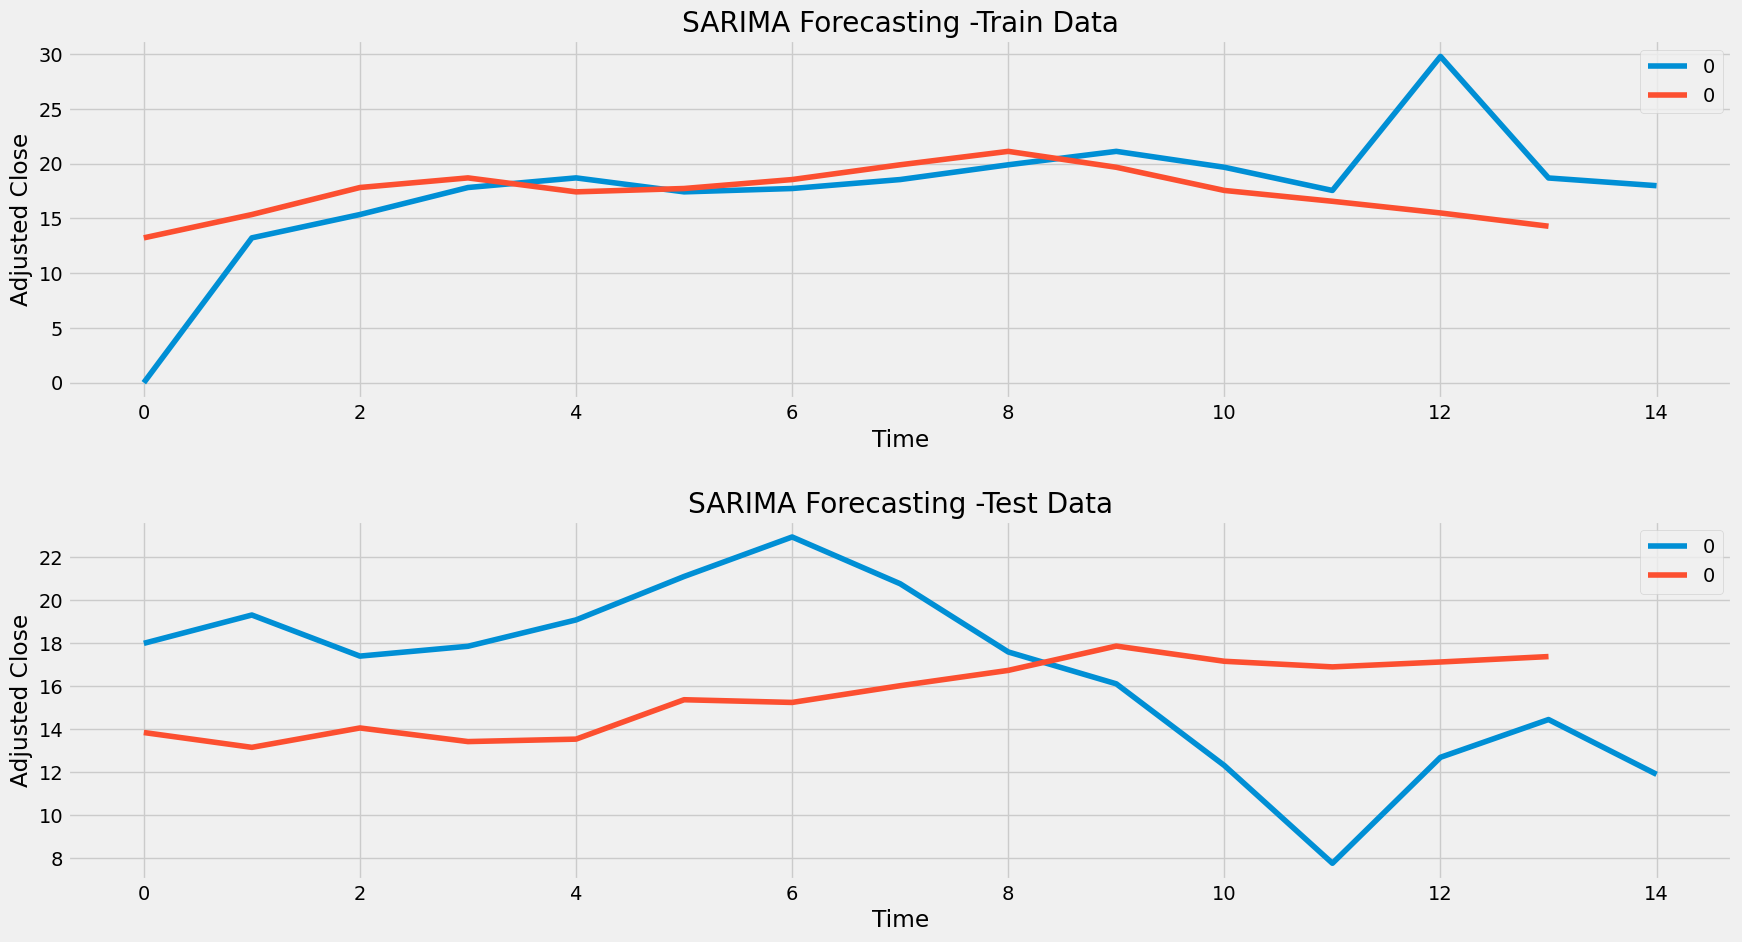

In [104]:
## Backtest iteration-1
backtest_model(train_list[1],test_list[1])

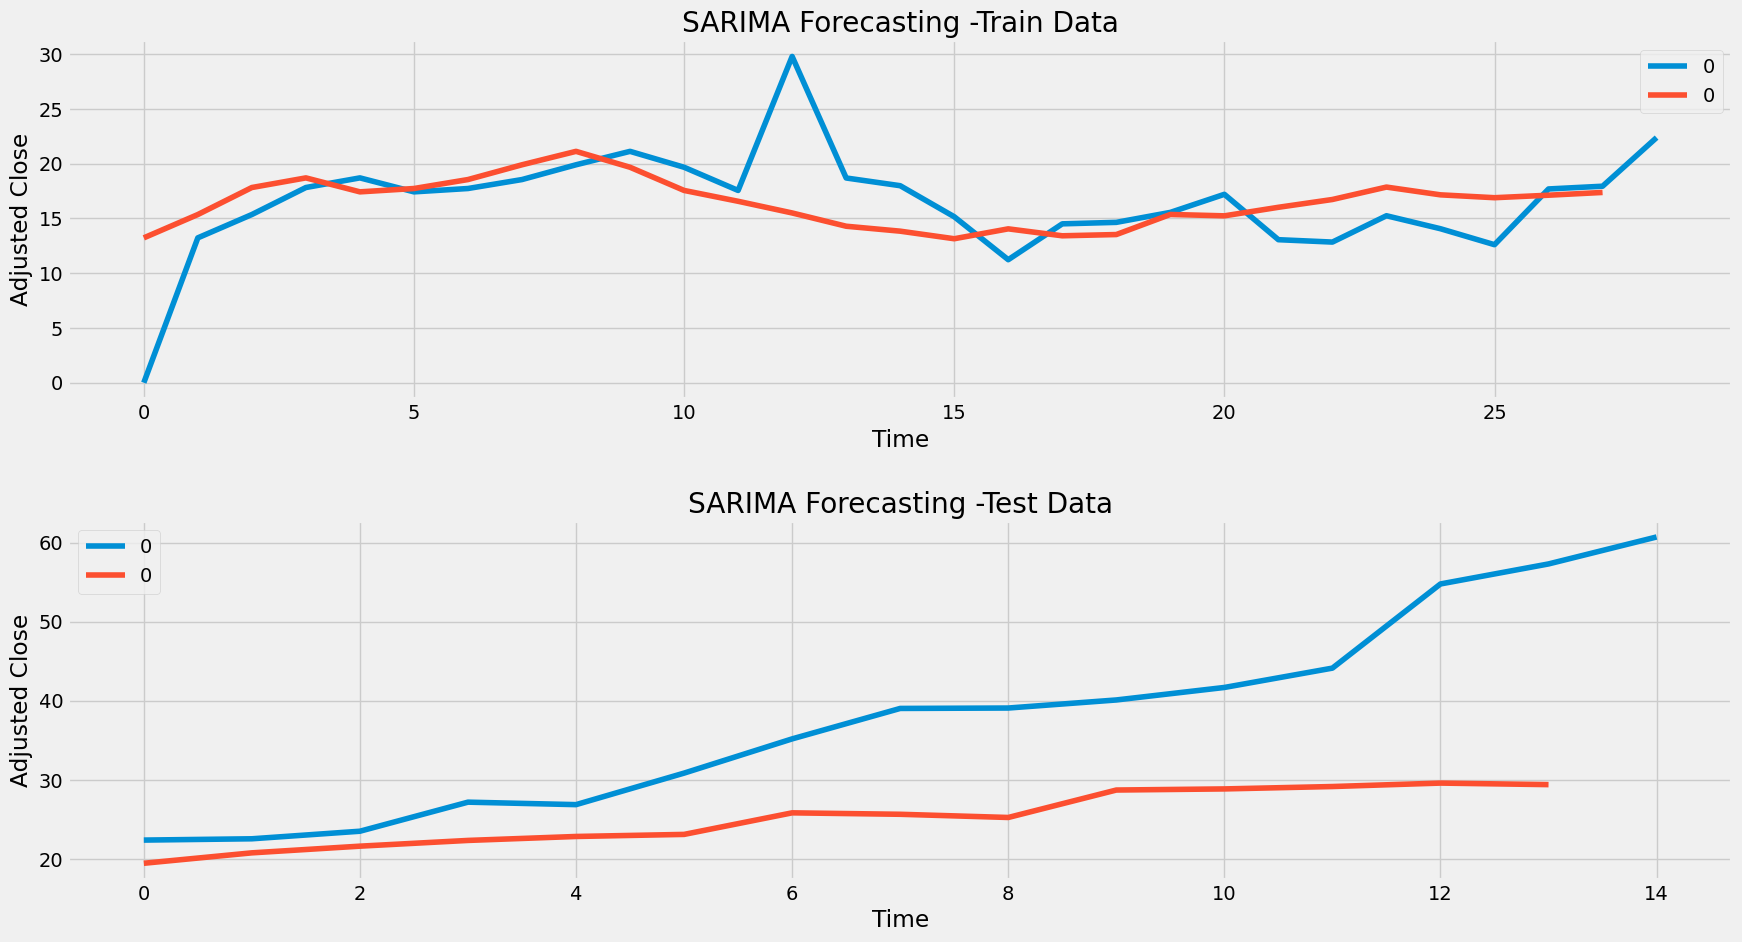

In [105]:
## Backtest Set-2
backtest_model(train_list[2],test_list[2])

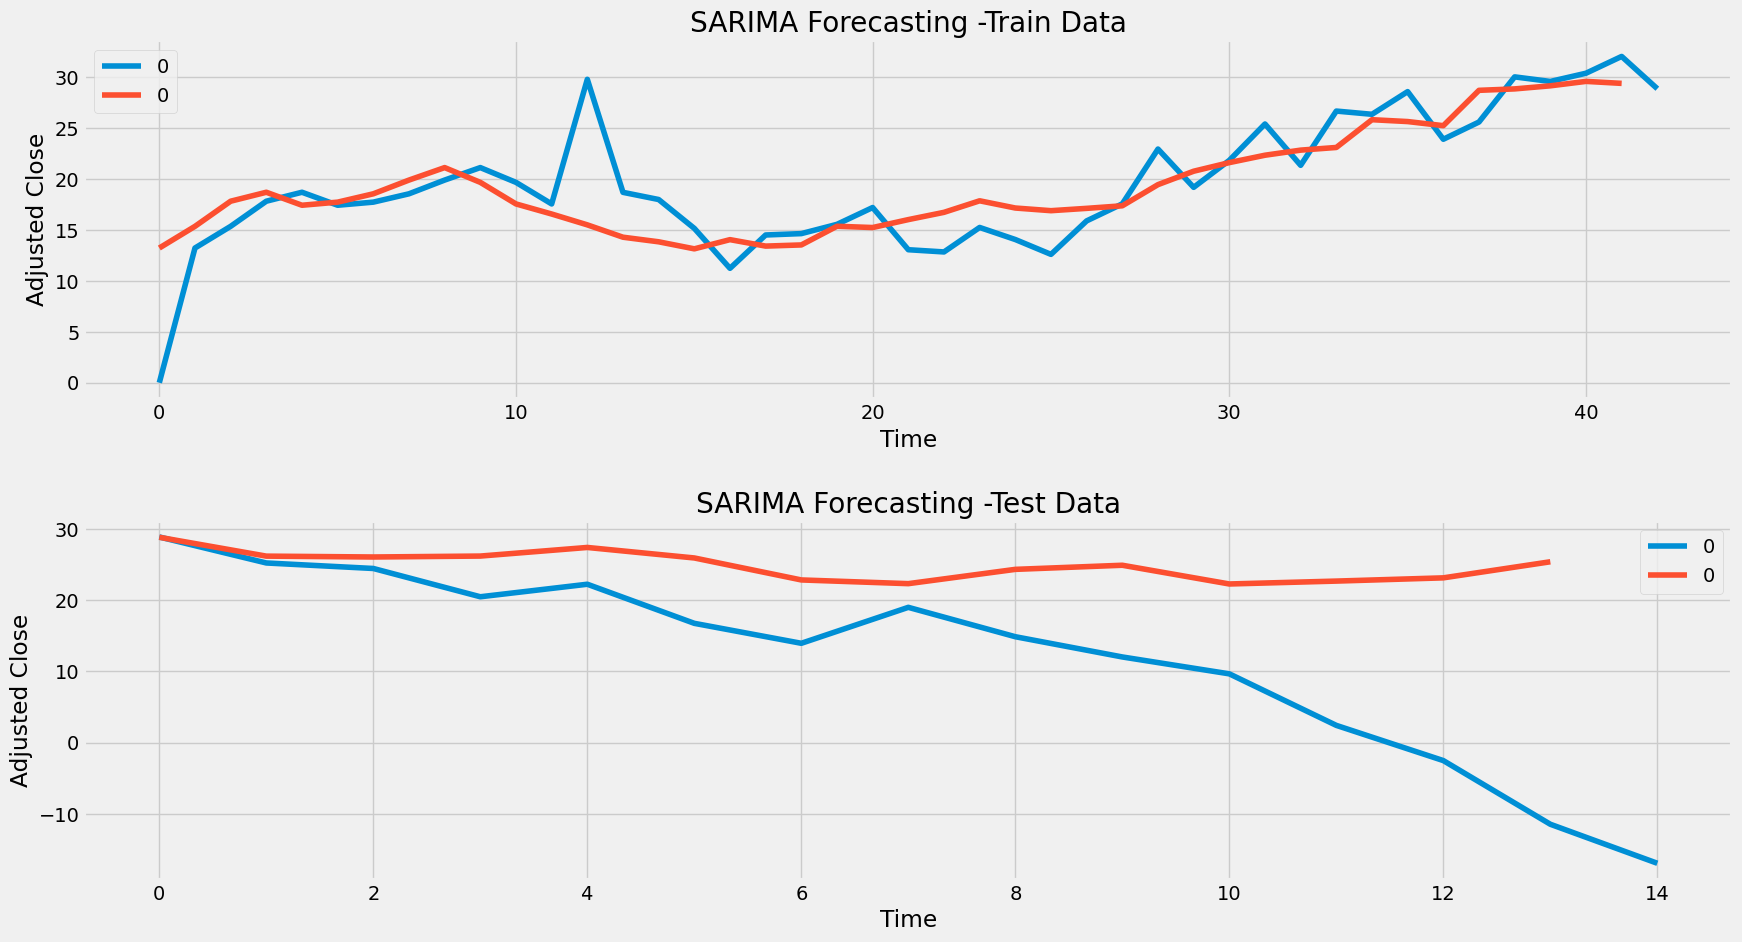

In [106]:
## Backtest Set-3
backtest_model(train_list[3],test_list[3])

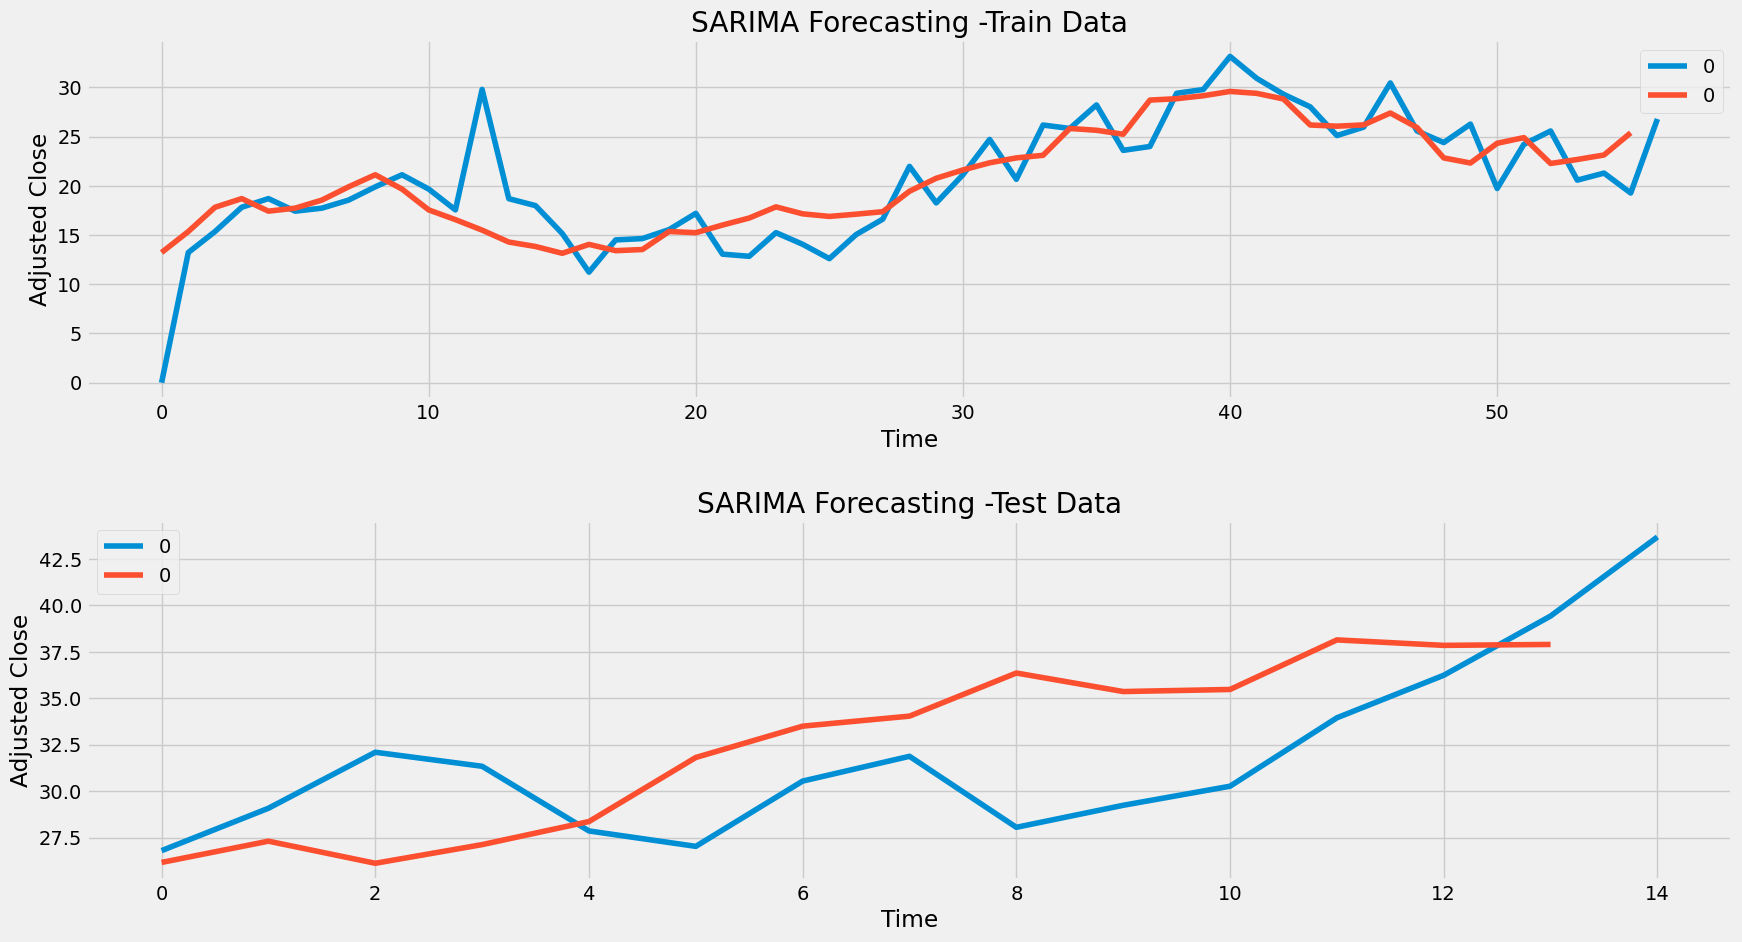

In [107]:
## Backtest Set-4
backtest_model(train_list[4],test_list[4])

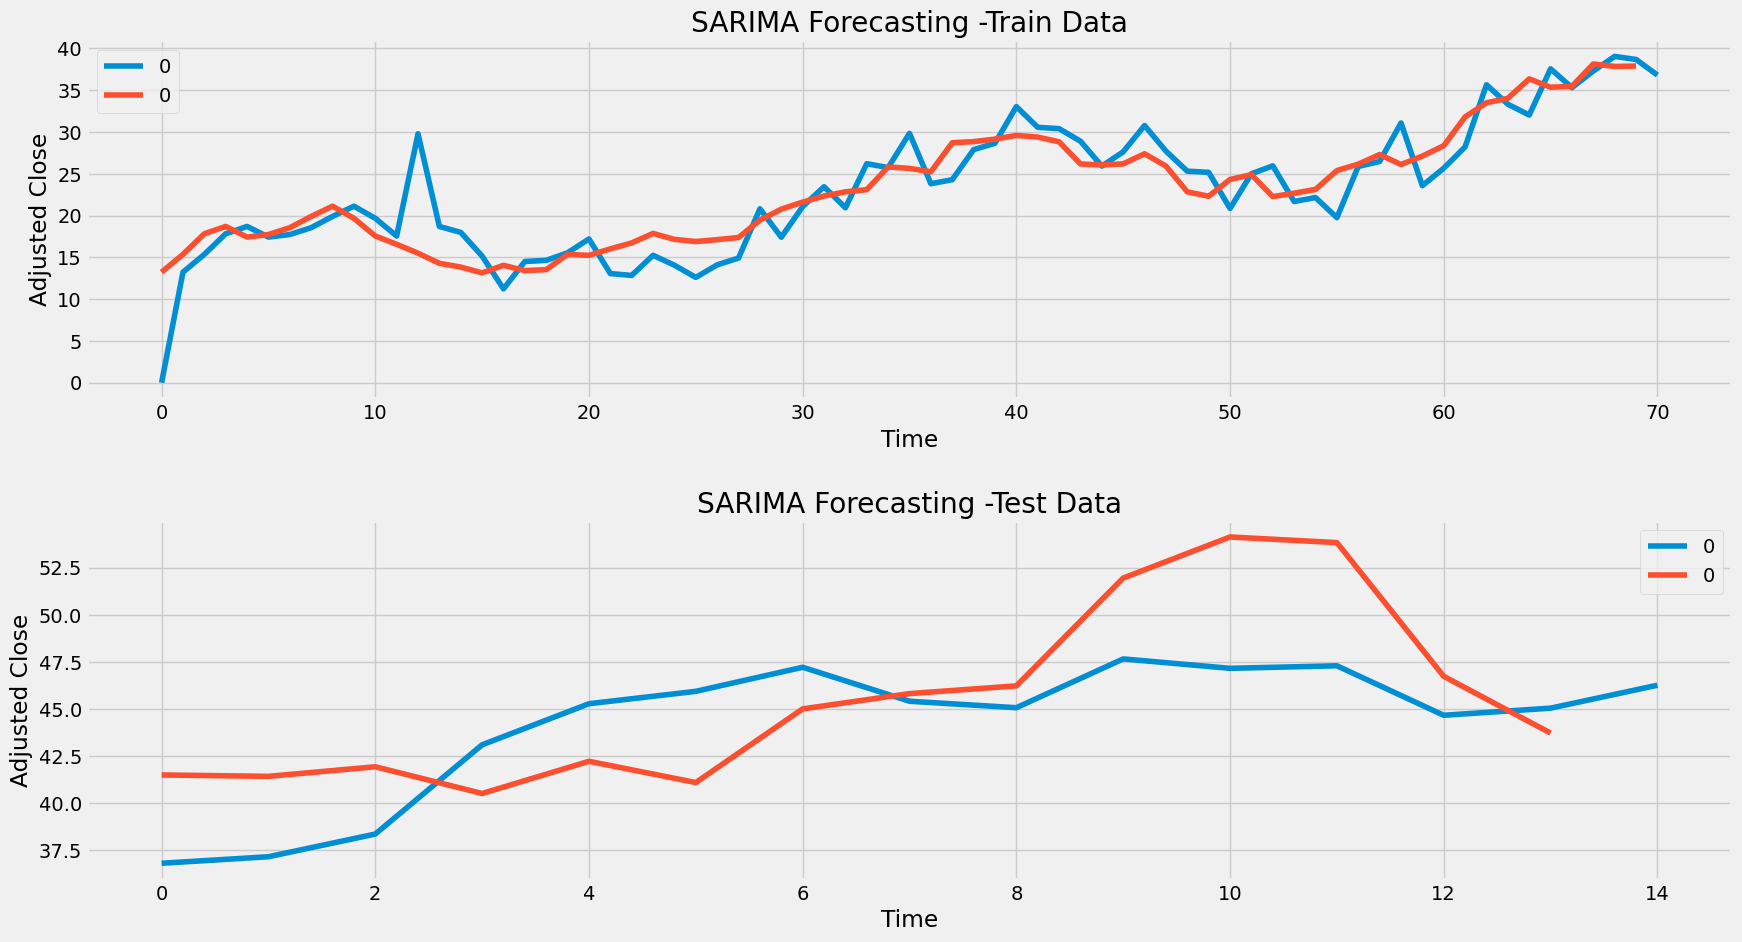

In [108]:
## Backtest Set-5
backtest_model(train_list[5],test_list[5])

## Forecasting with SARIMA

In [110]:
df_test_dropped_mean.head()

adj_close
date                 
2018-12-31  39.517496
2019-01-31  37.710871
2019-02-28  42.139501
2019-03-31  45.028120
2019-04-30  49.258986

In [112]:
#create an instance of SARIMA model
model = sm.tsa.SARIMAX(df_full_train_dropped_mean,order=(1,1,1),seasonal_order=(2,2,0,12))

# fit model to the data using fit method
model_fit = model.fit(disp=0)

# use model_fit object to make predictions using predict method
forecast_full_train = model_fit.predict(start='2012-01-31',end='2018-12-31')
forecast_test = model_fit.predict(start='2018-12-31',end='2020-09-30')

In [113]:
##Function to Calculate Evaluation Metrics
def evaluation_metrics(test_series, forecast_series, model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

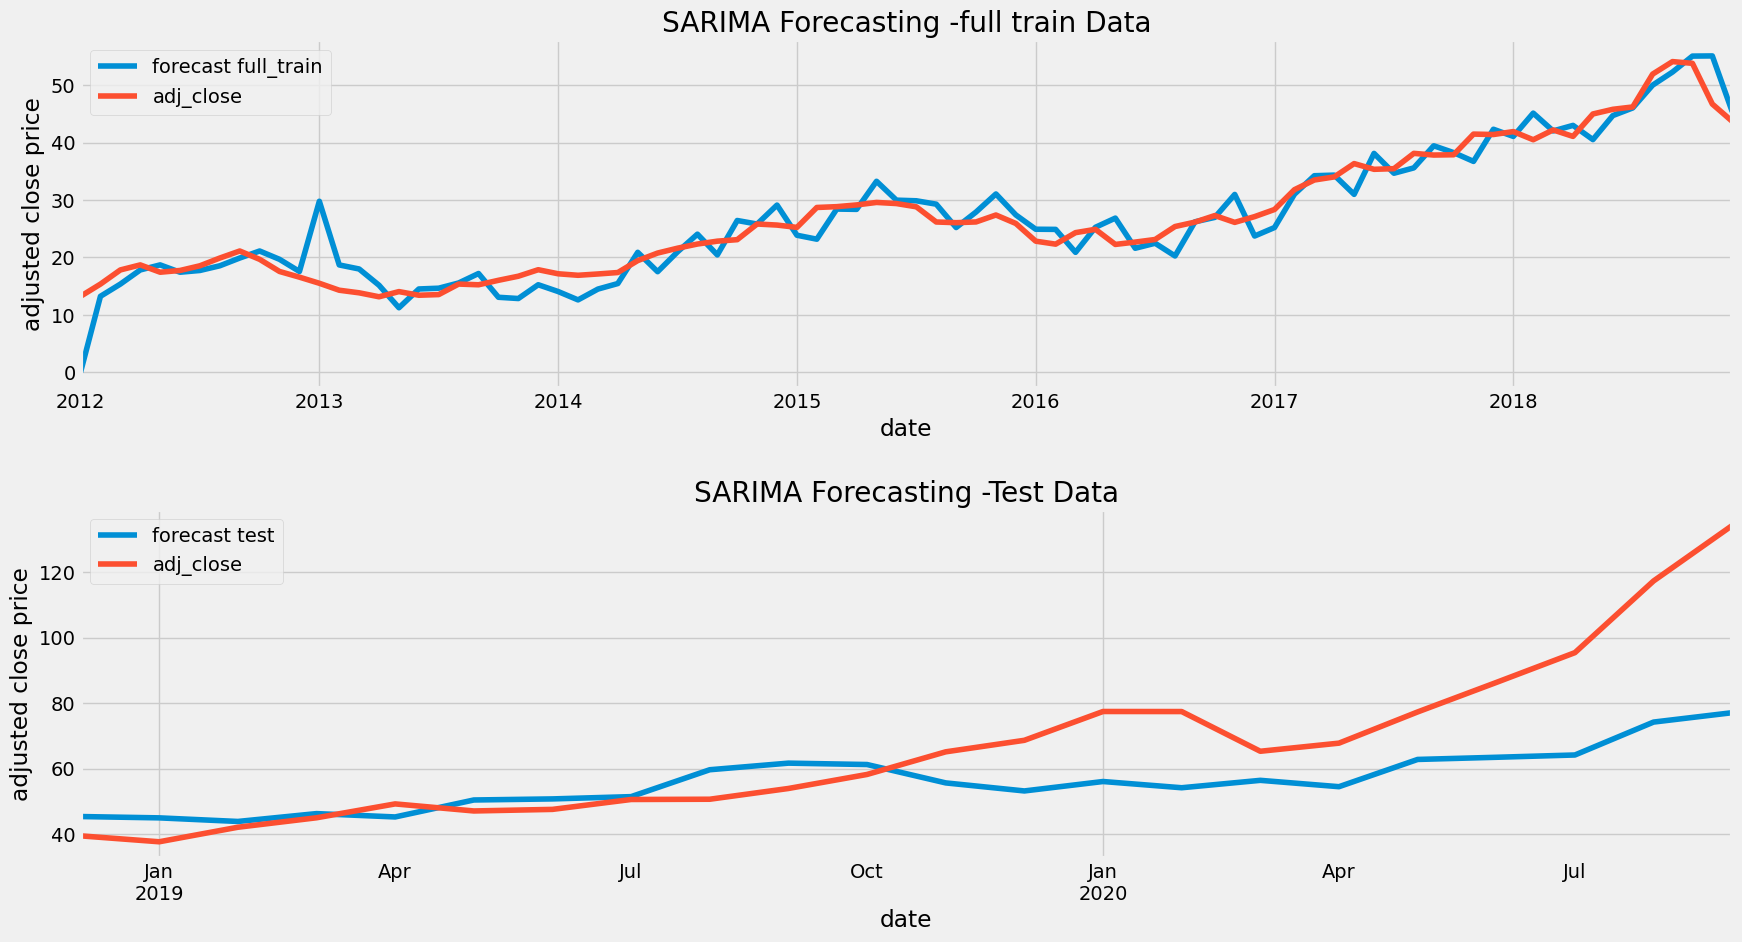

In [115]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecast_full_train.plot(label='forecast full_train',ax=ax1,title='SARIMA Forecasting -full train Data')
df_full_train_dropped_mean.plot(label='actual full train',ax=ax1)
ax1.set_ylabel('adjusted close price')


forecast_test.plot(label='forecast test',ax=ax2,title='SARIMA Forecasting -Test Data')
df_test_dropped_mean.plot(label='actual test',ax=ax2)
ax2.set_ylabel('adjusted close price')


handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)

plt.tight_layout(pad=2)

In [116]:
print(evaluation_metrics(df_full_train_dropped_mean,forecast_full_train,'SARIMA-Train Data'))
print('----')
print(evaluation_metrics(df_test_dropped_mean,forecast_test,'SARIMA-Test Data'))

Result Metrics for SARIMA-Train Data
R2 Score :  0.896
Mean Squared Error :  11.517
Mean Absolute Error :  2.419
None
----
Result Metrics for SARIMA-Test Data
R2 Score :  0.338
Mean Squared Error :  394.459
Mean Absolute Error :  13.986
None


In [117]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           adj_close   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(2, 2, [], 12)   Log Likelihood                -147.314
Date:                             Wed, 22 Feb 2023   AIC                            304.629
Time:                                     12:34:25   BIC                            315.016
Sample:                                 01-31-2012   HQIC                           308.684
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0350      0.755     -0.046      0.963      -1.515       1.445
ma.L1          0.2749      

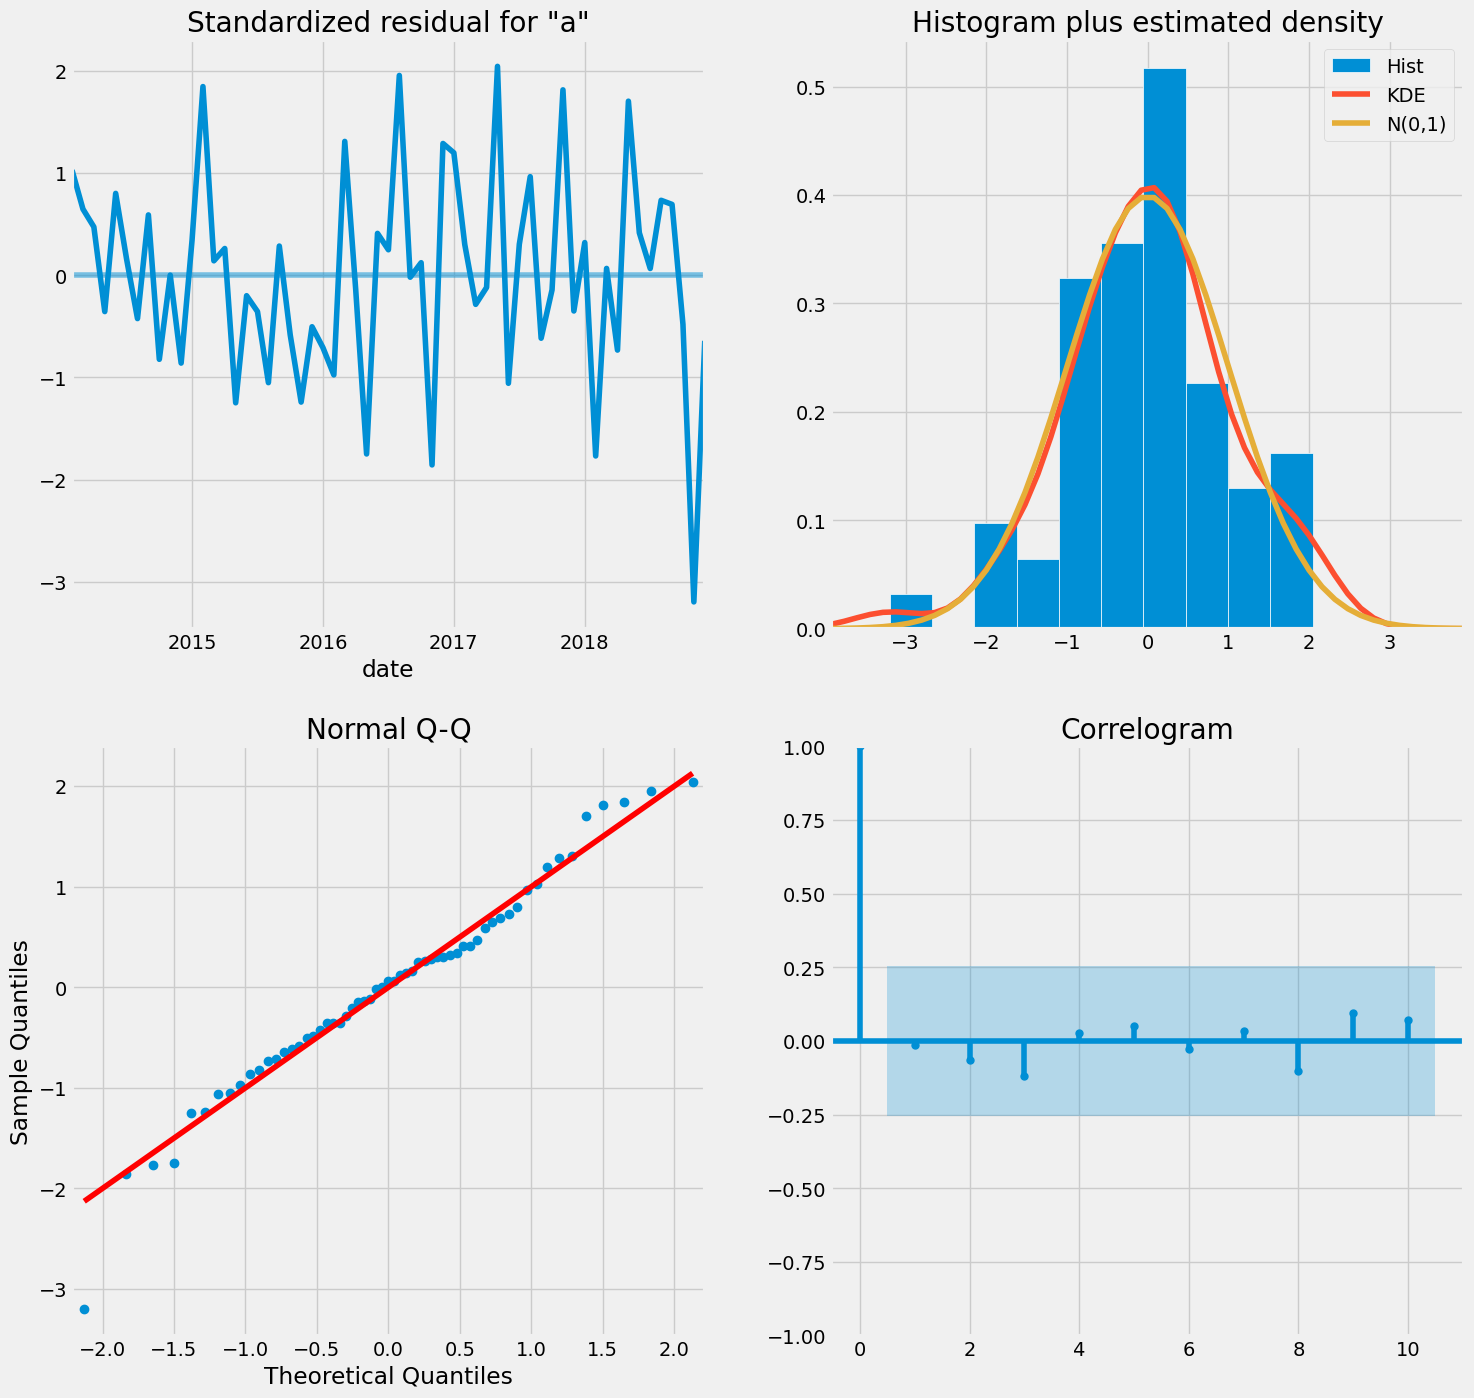

In [118]:
##Checking Model Diagnotics on Training Data
## https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html
model_fit.plot_diagnostics(figsize=(16, 16))
plt.show()   


## Training with Prophet

In [123]:
df_full_train_dropped.head()

date  adj_close
date                            
2012-01-03 2012-01-03  12.691425
2012-01-04 2012-01-04  12.759631
2012-01-05 2012-01-05  12.901293
2012-01-06 2012-01-06  13.036158
2012-01-09 2012-01-09  13.015480

In [124]:
df_full_train_prophet = df_full_train_dropped.copy()
df_test_prophet = df_test_dropped.copy()
df_val_prophet = df_val_dropped.copy()
df_train_prophet = df_train_dropped.copy()

In [125]:
##Prophet needs two columns in form of ds and y being Date and series
df_full_train_prophet.rename(columns={'date':'ds',
                   'adj_close':'y'},inplace=True)
df_test_prophet.rename(columns={'date':'ds',
                   'adj_close':'y'},inplace=True)
df_test_prophet.head()

ds          y
date                            
2018-12-07 2018-12-07  41.214645
2018-12-10 2018-12-10  41.486164
2018-12-11 2018-12-11  41.248890
2018-12-12 2018-12-12  41.363853
2018-12-13 2018-12-13  41.816387

**Training with prophet**

In [126]:
# Instantiate a Prophet object and fit the training data
model = Prophet()
model.fit(df_full_train_prophet)

# Make predictions on the test set
future = model.make_future_dataframe(periods=len(df_test_prophet), freq='D')
forecast = model.predict(future)

# Subset the test set predictions
test_forecast = forecast[-len(df_test_prophet):]

# Extract the actual values and predicted values
actual = df_test_prophet['y'].values
predicted = test_forecast['yhat'].values

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


**Calculating evaluation metrics**

- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)
- Root Mean Squared Error (RMSE)
- Symmetric Mean Absolute Percentage Error (SMAPE)
- Mean Absolute Scaled Error (MASE)

In [127]:
# Calculate the MAE
mae = mean_absolute_error(actual, predicted)
print('MAE: %.2f' % mae)

MAE: 12.69


In [128]:
# Calculate the MAPE
mape = (abs((actual - predicted) / actual)).mean() * 100
print("MAPE: %.2f%%"% mape)

MAPE: 18.11%


In [129]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print("RMSE: %.2f"% rmse)

RMSE: 18.04


In [130]:
# Calculate SMAPE
smape = (100/len(actual)) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))
print("SMAPE: %.2f%%" % smape)

SMAPE: 19.19%


In [131]:
# Calculate MASE
scaling_factor = np.mean(np.abs(np.diff(actual)))
mase = (np.abs(actual - predicted) / scaling_factor).mean()
print("MASE: %.2f" % mase)

MASE: 12.49


### Some useful plots for the prophet model training

1. Time series plot or, Forecast plot
2. Components plot
3. Cross-validation plot
4. Changepoints plot
5. Holidays Plot

1. Time-series plot: A simple time-series plot can help to visualize the trends and patterns in the data, as well as the predictions made by the Prophet model. We can plot the actual values and the predicted values on the same plot to compare the two.

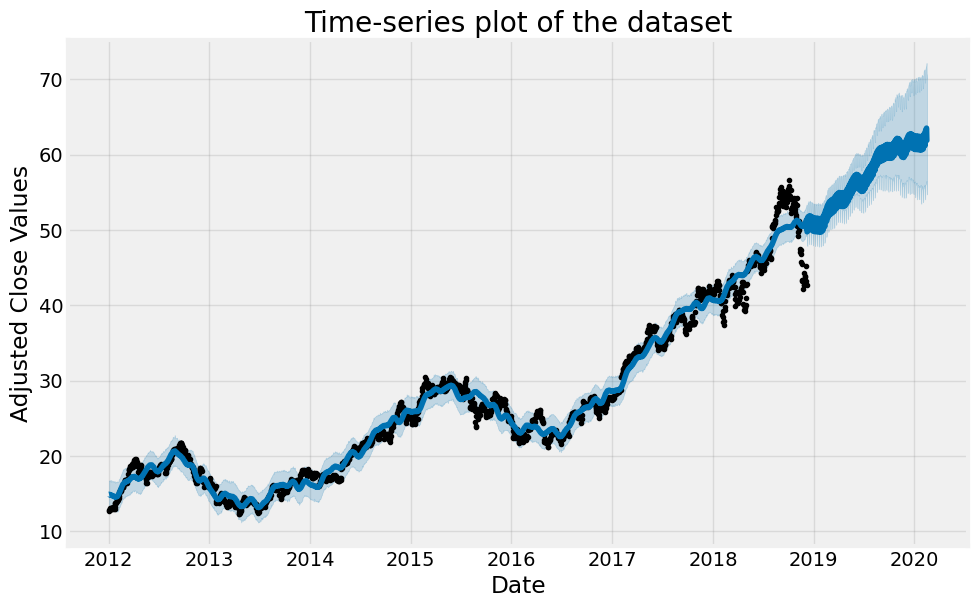

In [132]:
# plot the actual and predicted values
model.plot(forecast, xlabel='Date', ylabel='Adjusted Close Values')
plt.title('Time-series plot of the dataset')
plt.show()

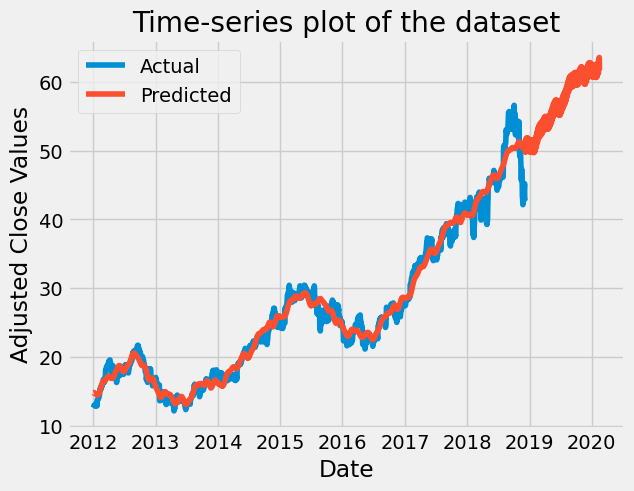

In [135]:
# plot the actual and predicted values
fig, ax = plt.subplots()
ax.plot(df_full_train_prophet['ds'], df_full_train_prophet['y'], label='Actual')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Values')
ax.set_title('Time-series plot of the dataset')
ax.legend()
plt.show()

2. Components plot: The Prophet model decomposes time-series data into its trend, seasonality, and holidays components. You can use the plot_components method to visualize these components separately, which can help you understand how each component contributes to the overall pattern in the data.

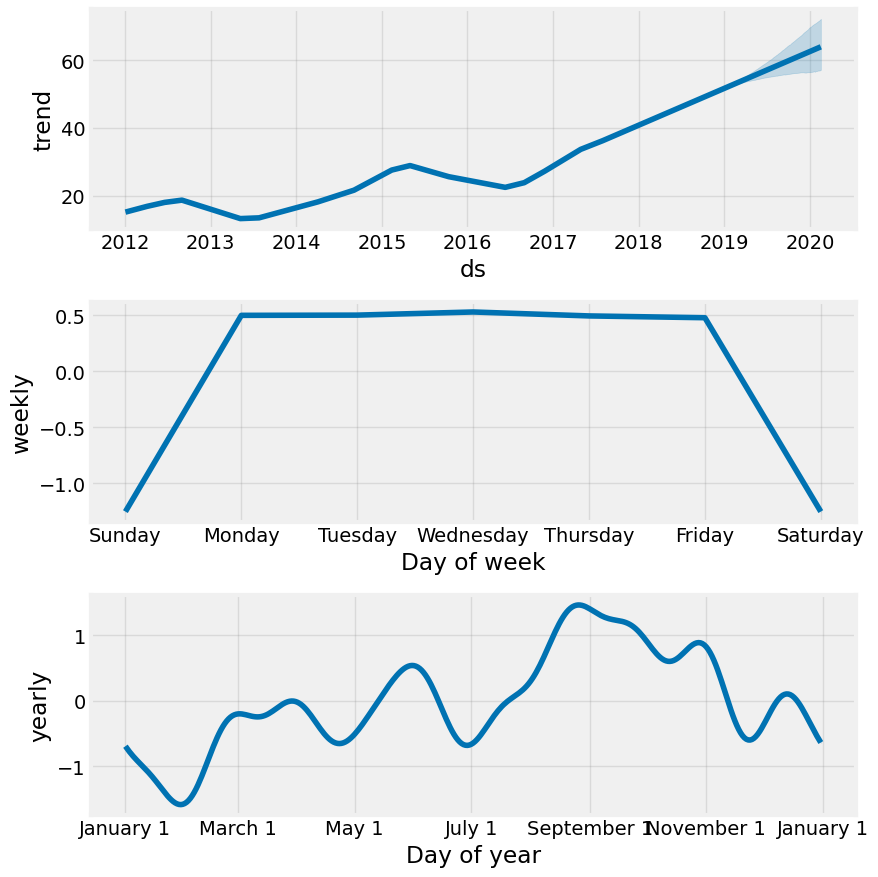

In [137]:
# Plot the components of the forecast
fig = model.plot_components(forecast)
plt.show()

4. Cross-validation plot: The cross_validation method in Prophet can be used to evaluate the performance of the model on historical data. The plot_cross_validation_metric method can be used to visualize the performance of the model over time, by plotting the mean absolute percentage error (MAPE) or another evaluation metric against the forecast horizon.

In [142]:
from prophet.plot import add_changepoints_to_plot, plot_components, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

In [143]:
len(df_full_train_prophet)

1744

In [144]:
len(df_test_prophet)

437

INFO:prophet:Making 2 forecasts with cutoffs between 2017-03-29 00:00:00 and 2017-09-25 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


AttributeError: 'Prophet' object has no attribute 'plot_cross_validation_metric'

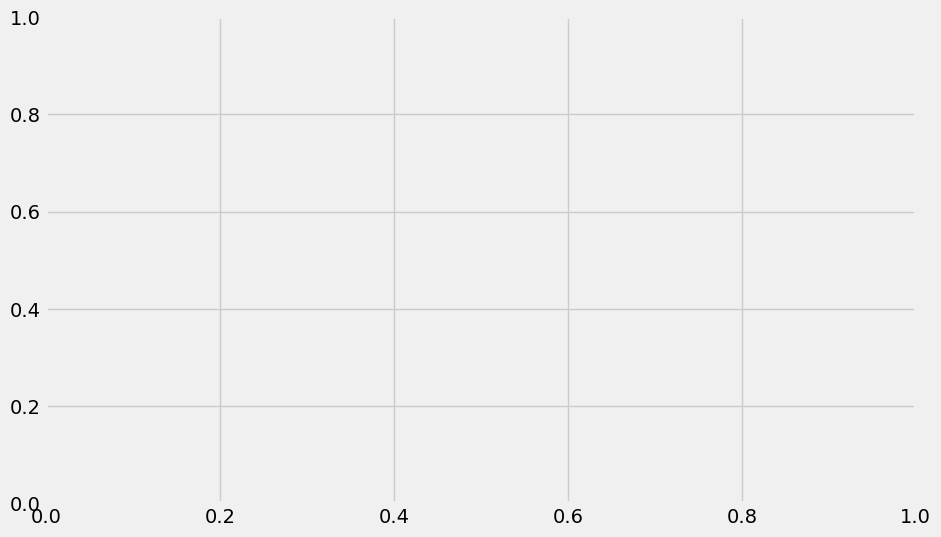

In [141]:
# Perform cross-validation
df_cv = cross_validation(model, initial=str(len(df_full_train_prophet))+'days', \
                         period='180 days', horizon = str(len(df_test_prophet))+'days')

# Calculate evaluation metrics for each fold
df_p = performance_metrics(df_cv)

# Plot the cross-validation results
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
model.plot_cross_validation_metric(df_cv, metric='mape', ax=ax)
plt.show()

5. Changepoint plot: The Prophet model identifies changepoints in the data, which are points in time where the underlying pattern changes. You can use the changepoint_prior_scale parameter in Prophet to adjust the sensitivity of the model to changepoints, and the plot_changepoints method to visualize the locations of the changepoints.

6. Holidays plot: The Prophet model allows you to include holidays and other special events that can affect the time-series data. You can use the add_country_holidays method to add holidays for a specific country, and the plot_forecast_component method to visualize the effect of holidays on the forecast.

**References**:

1. [Introduction to the Fundamentals of Time Series Data and Analysis](https://www.aptech.com/blog/introduction-to-the-fundamentals-of-time-series-data-and-analysis/)
2. [Time Series Modelling & Stock Forecasting in Python](https://github.com/sukritishuk/ML_ZoomCamp_Article)
3. [Working with Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)
5. [Interpreting ACF and PACF Plots for Time Series Forecasting](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)
6. [https://github.com/nikhils10/Time-Series-Forecasting-Apple-Stock-Price-Using-SARIMA-Prophet](https://github.com/nikhils10/Time-Series-Forecasting-Apple-Stock-Price-Using-SARIMA-Prophet)
2. [A modern Time Series tutorial](https://www.kaggle.com/code/rohanrao/a-modern-time-series-tutorial)